In [1]:
from paths import models_folder, metadata_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_strid

In [6]:
model_path = models_folder / "model_conv_32_16_8_4_stride_4_B1H_Inst_center_scale_100_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_4_stride_4_B1H_Inst_center_scale_100_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_4_stride_4_B1H_Inst_center_scale_100_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# remove shuffling
model_metadata["generator"]["shuffle"] = True  # True because I don't have the seen values indices
# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 512, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 8)             904       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 8)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 4)              2

Feb/23 16:34:16 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 16:34:16 pyobsbox.generator INFO: shuffle: True
Feb/23 16:34:16 pyobsbox.generator INFO: seed: 42
Feb/23 16:34:16 pyobsbox.generator INFO: batch_size: 8192
Feb/23 16:34:16 pyobsbox.generator INFO: sequence_length: 2048
Feb/23 16:34:16 pyobsbox.generator INFO: n_bunches: 256
Feb/23 16:34:16 pyobsbox.generator INFO: __len__: 1037
Feb/23 16:34:16 pyobsbox.generator INFO: fetched_log_folder: None
Feb/23 16:34:16 pyobsbox.generator INFO: fetched_log_prefix: 
Feb/23 16:34:16 pyobsbox.generator INFO: normalization: center_scale
Feb/23 16:34:16 pyobsbox.generator INFO: normalization_pre_split: False
Feb/23 16:34:16 pyobsbox.generator INFO: normalization_kwargs: {'scale_factor': 100}
Feb/23 16:34:16 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 16:34:16 pyobsbox.

In [9]:
print(train_metadata.shape)
train_metadata.head()

(265472, 11)


type  fill  beam plane  q           date_time  \
7246487  Inst  6919     1     h  7 2018-07-13 18:25:14   
6889956  Inst  7464     1     h  7 2018-11-22 05:09:14   
1618768  Inst  6663     1     h  7 2018-05-10 15:13:15   
6142312  Inst  6953     1     h  7 2018-07-21 06:32:07   
594002   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7246487  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/...       2556   
6889956  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7464/...        460   
1618768  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6142312  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/...       2556   
594002   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7246487        916.0         652.0      65536  
6889956       2509.0         334.0      65536  
1618768       3181.0        2357.0      65536  
6142312        721.0         530.0      65536  
594002        2920.0        1609.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


type  fill  beam plane  q           date_time  \
6533943  Inst  6576     1     h  7 2018-04-19 19:24:14   
4282715  Inst  6709     1     h  7 2018-05-20 22:06:14   
3488955  Inst  7481     1     h  7 2018-11-28 09:33:15   
1626507  Inst  6245     1     h  7 2017-09-27 01:08:14   
5281100  Inst  6706     1     h  7 2018-05-20 09:57:14   

                                                      file  n_bunches  \
6533943  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6576/...        252   
4282715  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/...       2556   
3488955  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7481/...        166   
1626507  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   
5281100  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/...        987   

         bunch_index  bunch_number  ts_length  
6533943        698.0         206.0      65536  
4282715       1752.0        1278.0      65536  
3488955        622.0         128.0      65536  
1626507       1021.0         561.0      65536  
5281100       2285.0         650.0      65536

# Loss functions

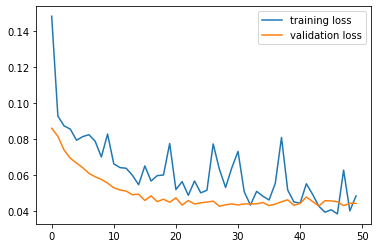

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

This model could be trained deeper, because it is deeper.

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(40960, 2048, 1)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 52s 1s/step


(409600, 2048, 1)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 4s 762ms/step


(40960, 2048, 1)

In [16]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [17]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
MAE_validation.shape

(40960,)

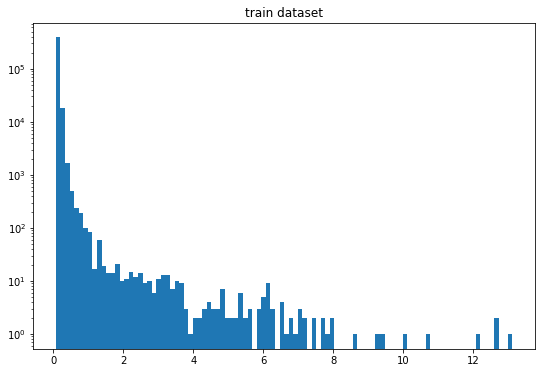

In [18]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [19]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.07442340039415285

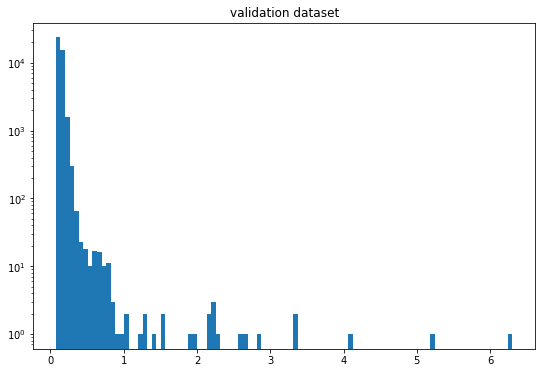

In [20]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [21]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.07442340039415285

In [22]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [23]:
max_MAE_indices

array([269528, 259166, 243619, ...,  88260, 269253,  14281])

In [24]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  269528
MAE:  13.12158100922592
n_bunches       2175
bunch_index      145
bunch_number      83
Name: 9982559, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_14h34m14s.h5


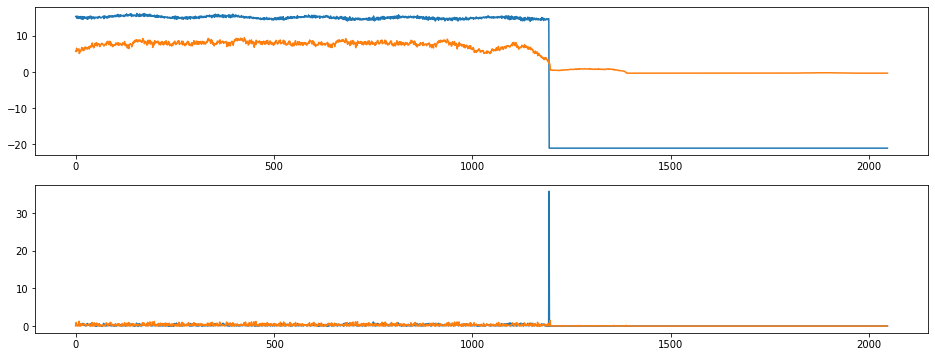

In [25]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  269528
MAE:  13.12158100922592
n_bunches       2175
bunch_index      145
bunch_number      83
Name: 9982559, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_14h34m14s.h5


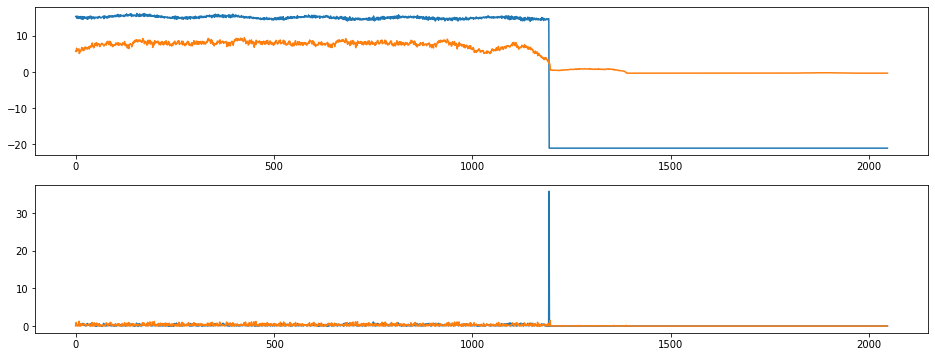

index:  259166
MAE:  12.643158903981966
n_bunches        987
bunch_index     3129
bunch_number     848
Name: 8437044, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h26m14s.h5


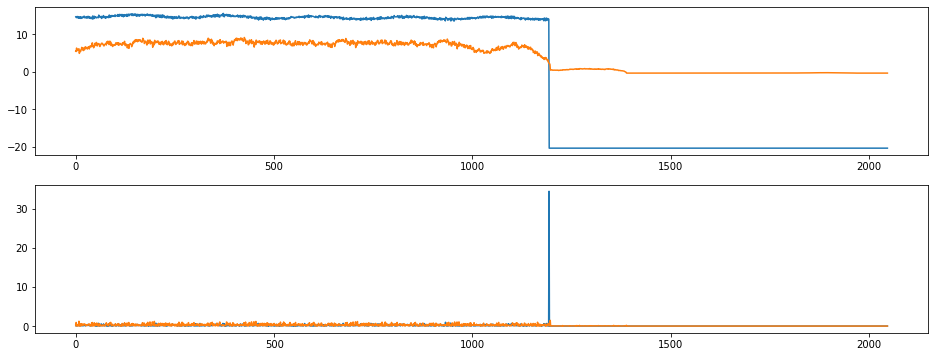

index:  243619
MAE:  12.637404030905746
n_bunches       1836
bunch_index      357
bunch_number     184
Name: 4782102, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_12h27m14s.h5


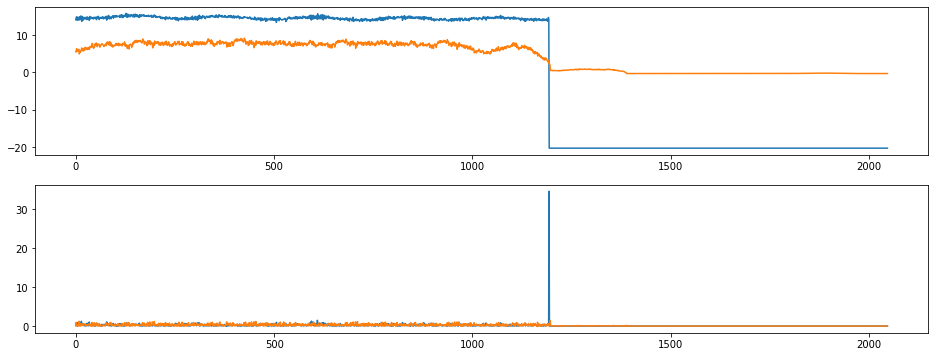

index:  108393
MAE:  12.127495713512761
n_bunches       670
bunch_index     297
bunch_number     60
Name: 3411356, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181123_01h57m14s.h5


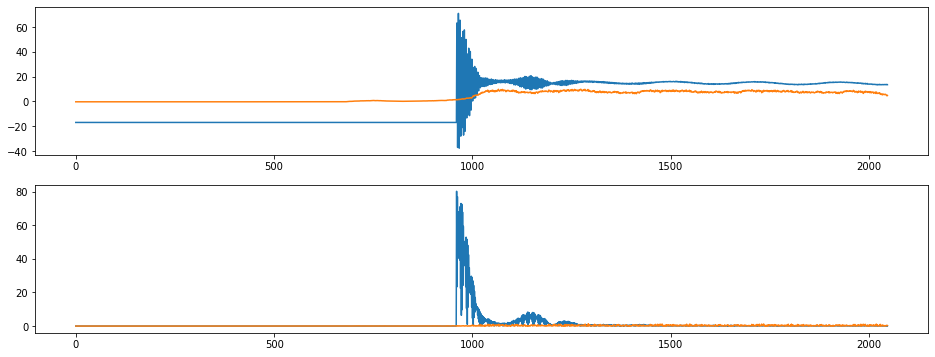

index:  375550
MAE:  10.665928978757002
n_bunches        339
bunch_index     1983
bunch_number     221
Name: 2707765, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6594/instability_data/06594_Inst_B1H_Q7_20180422_12h42m14s.h5


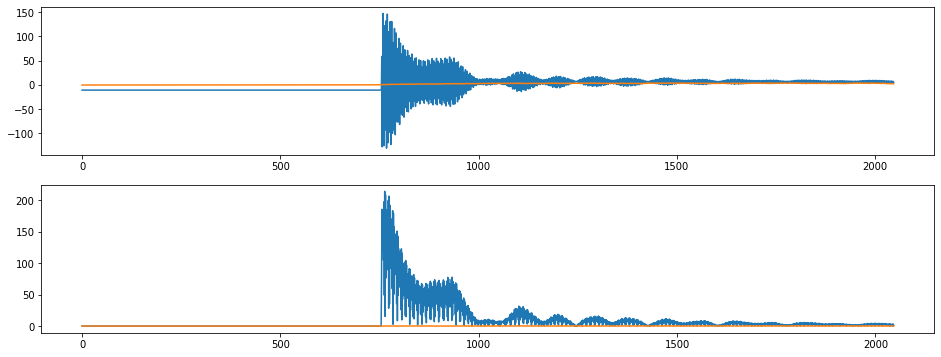

index:  142396
MAE:  10.050678652048225
n_bunches       2556
bunch_index     1739
bunch_number    1265
Name: 4486517, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_16h14m13s.h5


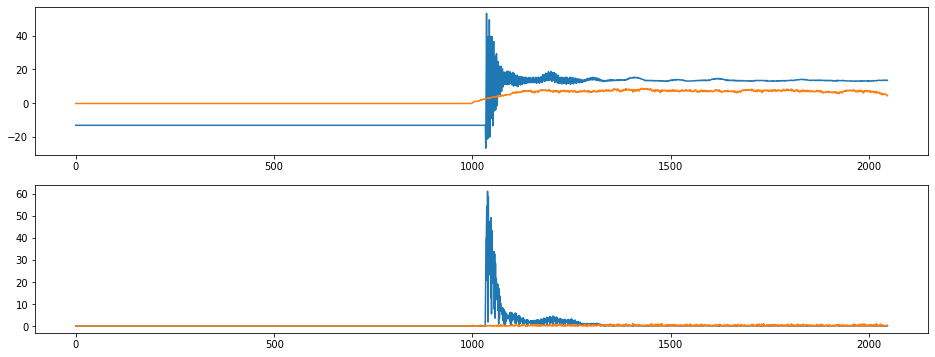

index:  85943
MAE:  9.349371561761654
n_bunches       924
bunch_index     688
bunch_number    497
Name: 4509005, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7270/instability_data/07270_Inst_B1H_Q7_20181009_00h01m14s.h5


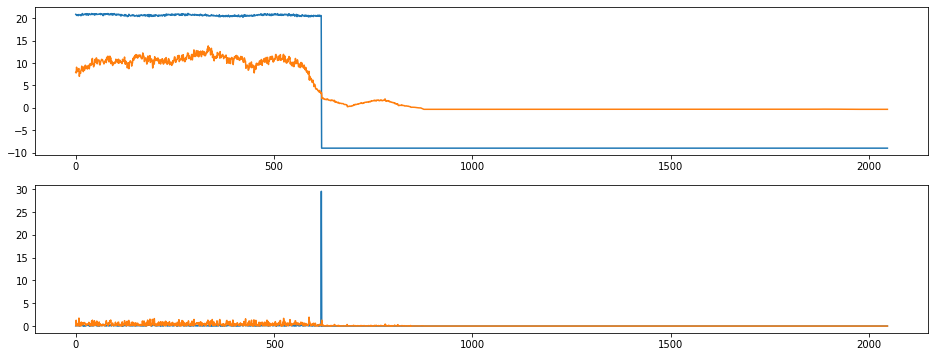

index:  194059
MAE:  9.32827551486931
n_bunches       276
bunch_index     328
bunch_number    137
Name: 6247712, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7366/instability_data/07366_Inst_B1H_Q7_20181027_02h23m59s.h5


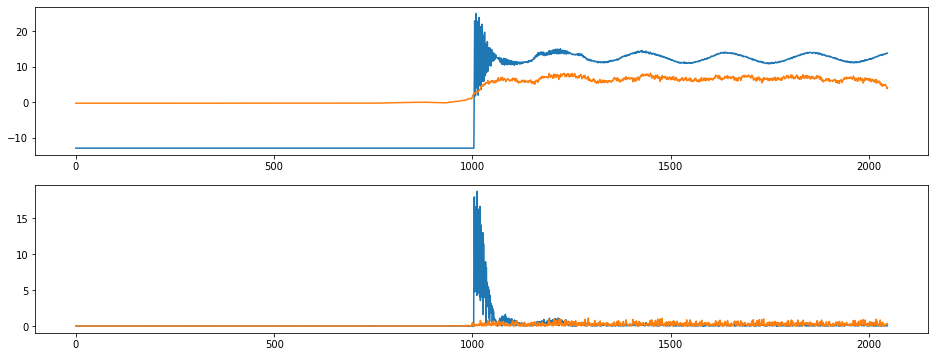

index:  250521
MAE:  8.586611178891037
n_bunches        152
bunch_index     2220
bunch_number      97
Name: 304460, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7299/instability_data/07299_Inst_B1H_Q7_20181014_04h31m14s.h5


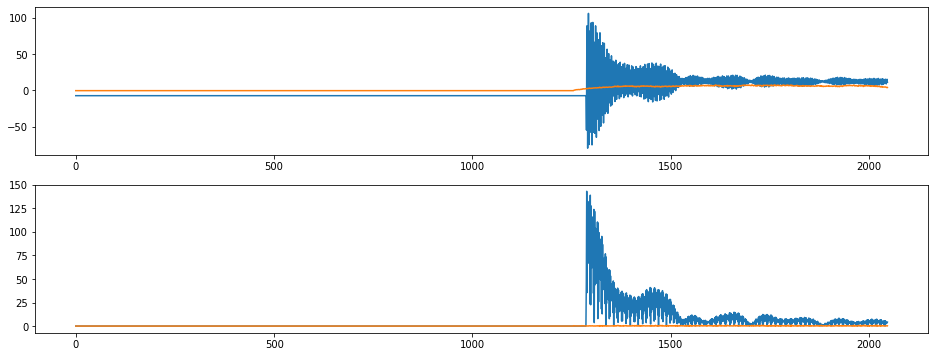

index:  407490
MAE:  8.025864824847377
n_bunches       2556
bunch_index     3330
bunch_number    2480
Name: 6867955, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7135/instability_data/07135_Inst_B1H_Q7_20180907_23h18m14s.h5


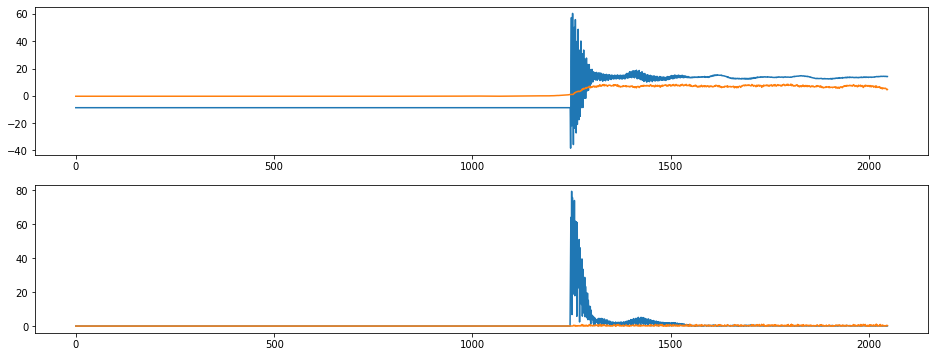

In [26]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  14281
MAE:  0.07442340039415285
n_bunches       1068
bunch_index     1002
bunch_number     731
Name: 9443751, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6918/instability_data/06918_Inst_B1H_Q7_20180713_02h00m18s.h5


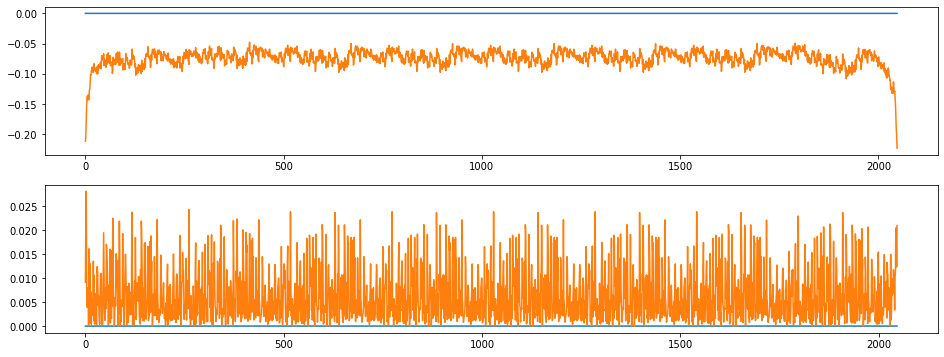

index:  269253
MAE:  0.07442340039415285
n_bunches       796
bunch_index     114
bunch_number     56
Name: 4829296, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h41m05s.h5


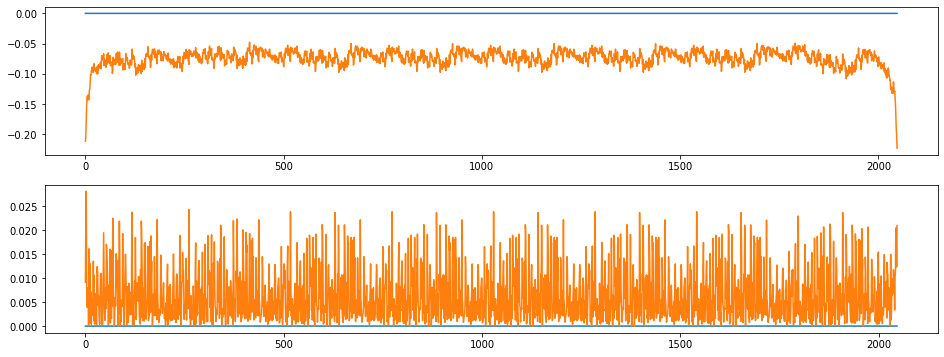

index:  88260
MAE:  0.07442340039415285
n_bunches        987
bunch_index     2385
bunch_number     743
Name: 215784, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6901/instability_data/06901_Inst_B1H_Q7_20180708_04h11m22s.h5


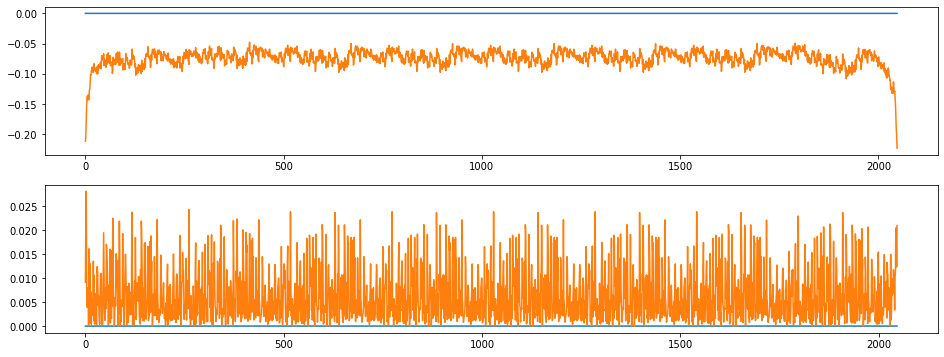

index:  88242
MAE:  0.07442340039415285
n_bunches       636
bunch_index     710
bunch_number    500
Name: 5118314, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6749/instability_data/06749_Inst_B1H_Q7_20180601_03h52m19s.h5


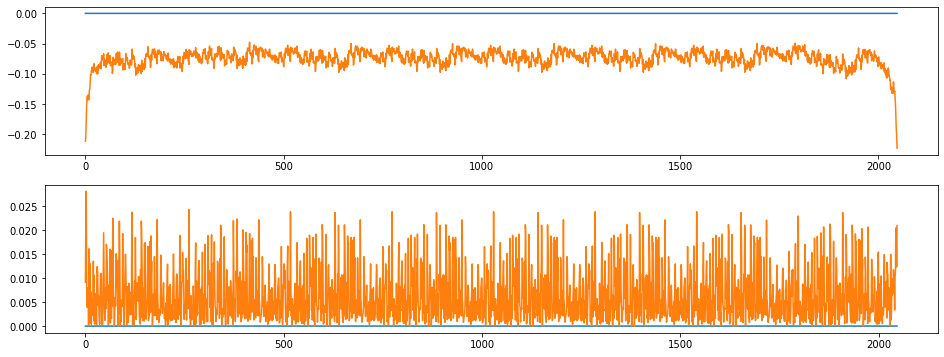

index:  51862
MAE:  0.07442340039415285
n_bunches       588
bunch_index     445
bunch_number    210
Name: 4120617, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6807/instability_data/06807_Inst_B1H_Q7_20180616_03h48m14s.h5


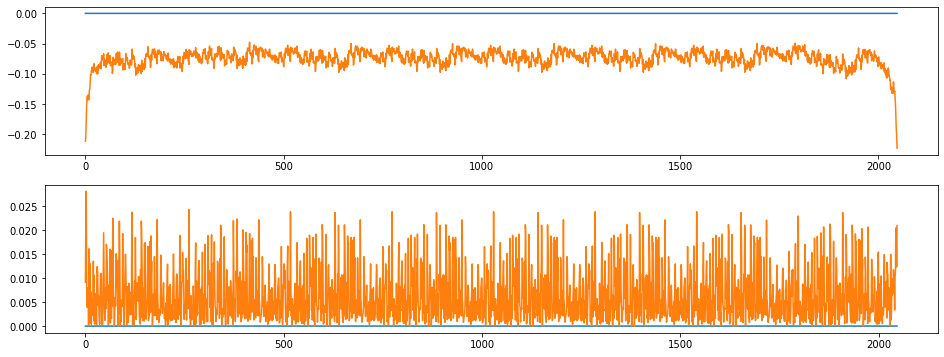

index:  88148
MAE:  0.07442340039415285
n_bunches       1916
bunch_index     2784
bunch_number    1536
Name: 9912029, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170925_21h04m53s.h5


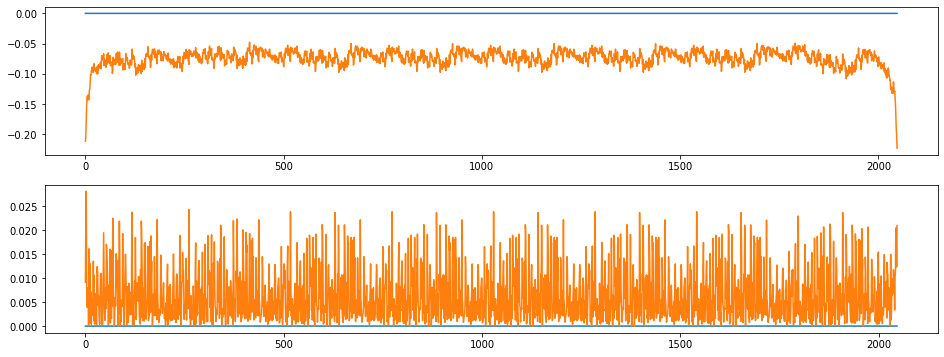

index:  166335
MAE:  0.07442340039415285
n_bunches       2556
bunch_index     1552
bunch_number    1146
Name: 10399679, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7117/instability_data/07117_Inst_B1H_Q7_20180902_06h59m16s.h5


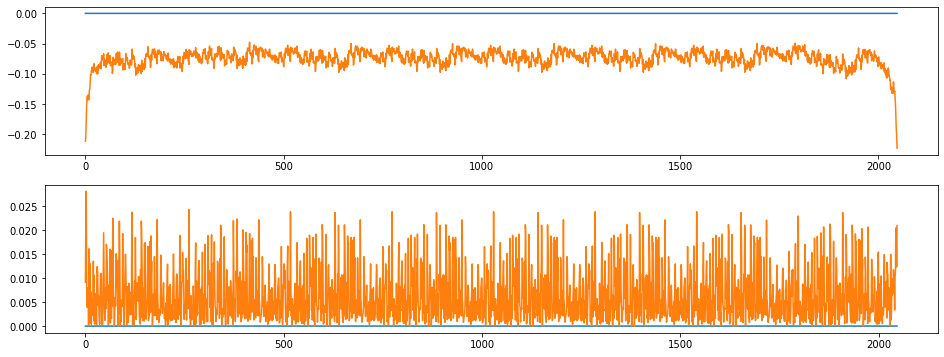

index:  88126
MAE:  0.07442340039415285
n_bunches       228
bunch_index     718
bunch_number     62
Name: 10126666, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6220/instability_data/06220_Inst_B1H_Q7_20170917_22h49m14s.h5


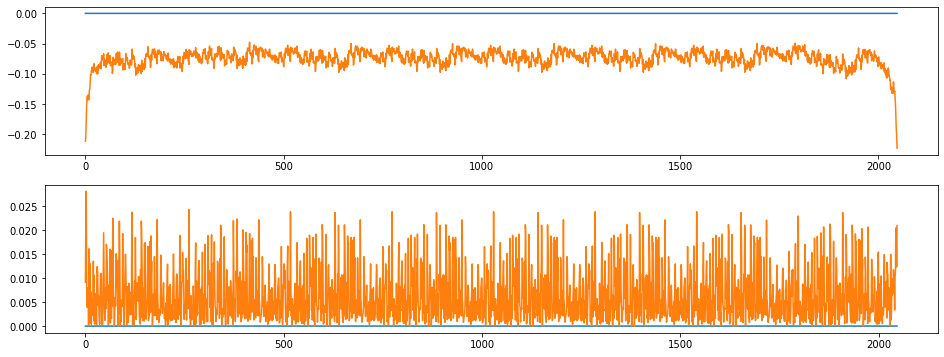

index:  269492
MAE:  0.07442340039415285
n_bunches       1092
bunch_index       79
bunch_number      44
Name: 7430694, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6603/instability_data/06603_Inst_B1H_Q7_20180423_19h49m18s.h5


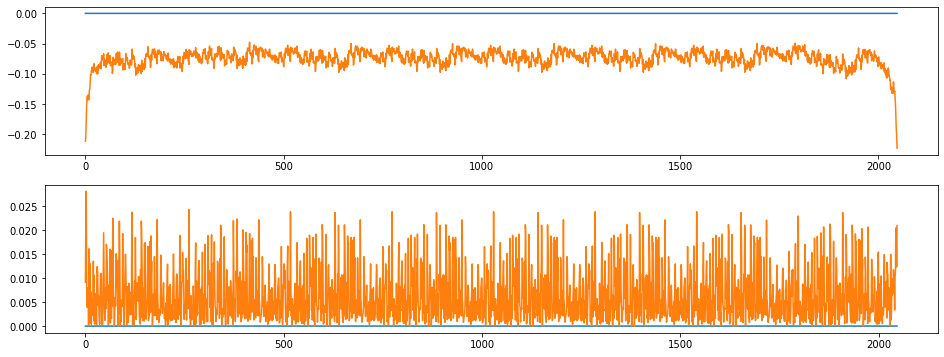

index:  269540
MAE:  0.07442340039415285
n_bunches       300
bunch_index     162
bunch_number    100
Name: 8321322, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6898/instability_data/06898_Inst_B1H_Q7_20180708_00h49m42s.h5


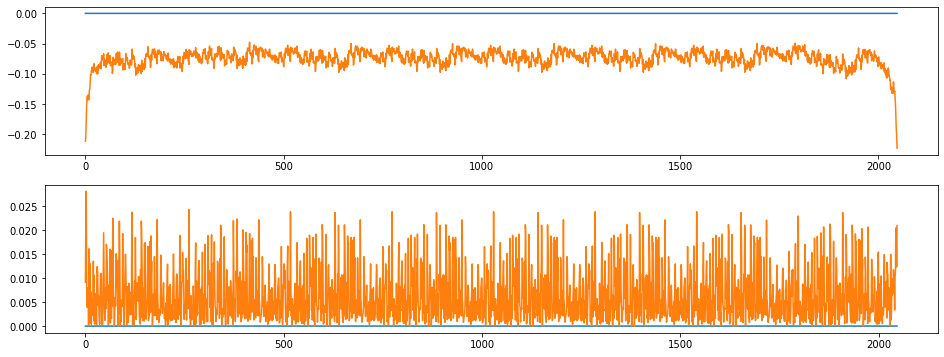

In [27]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [28]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  14281
MAE:  0.07442340039415285
n_bunches       1068
bunch_index     1002
bunch_number     731
Name: 9443751, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6918/instability_data/06918_Inst_B1H_Q7_20180713_02h00m18s.h5


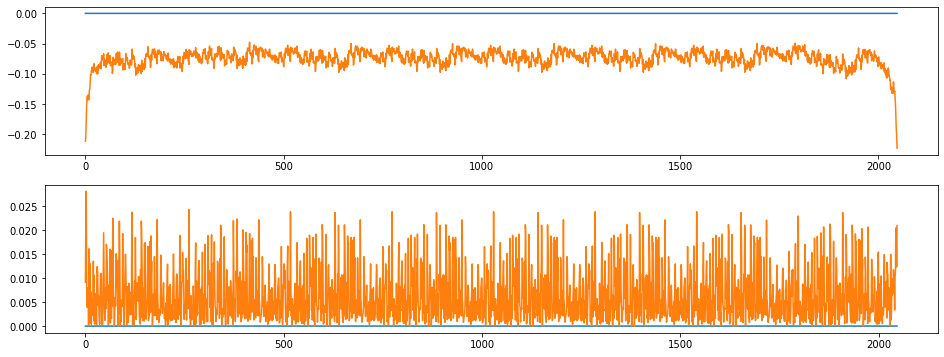

index:  269253
MAE:  0.07442340039415285
n_bunches       796
bunch_index     114
bunch_number     56
Name: 4829296, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h41m05s.h5


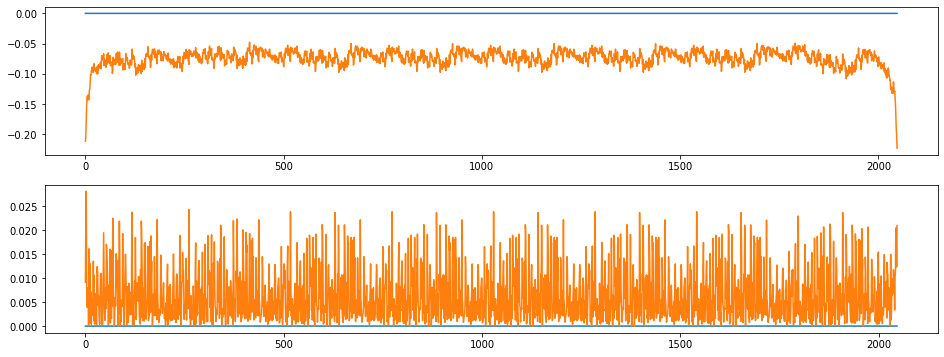

index:  88260
MAE:  0.07442340039415285
n_bunches        987
bunch_index     2385
bunch_number     743
Name: 215784, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6901/instability_data/06901_Inst_B1H_Q7_20180708_04h11m22s.h5


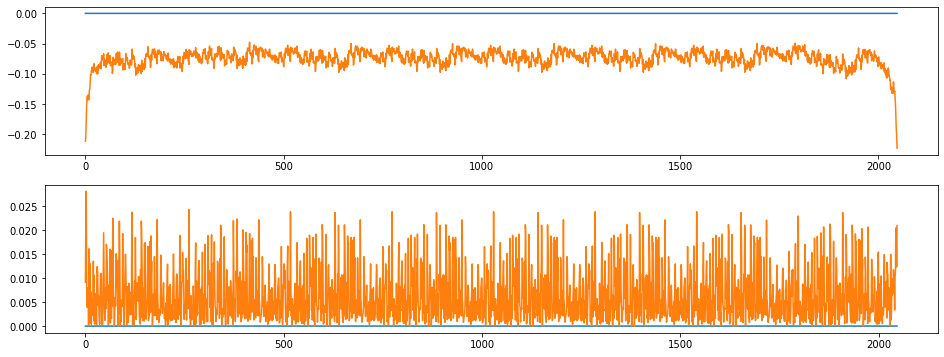

index:  88242
MAE:  0.07442340039415285
n_bunches       636
bunch_index     710
bunch_number    500
Name: 5118314, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6749/instability_data/06749_Inst_B1H_Q7_20180601_03h52m19s.h5


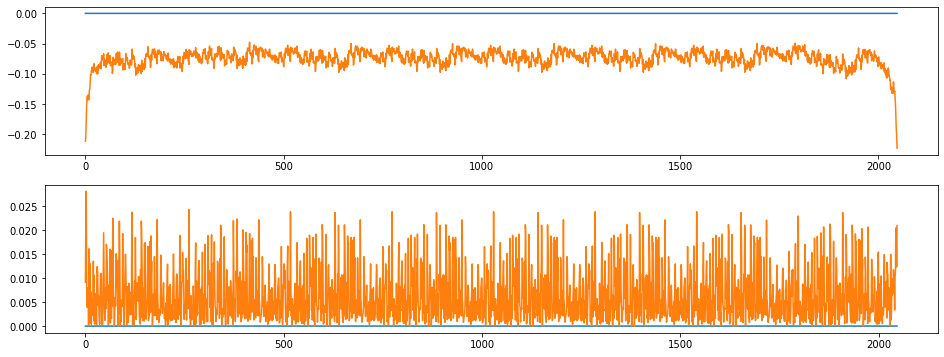

index:  51862
MAE:  0.07442340039415285
n_bunches       588
bunch_index     445
bunch_number    210
Name: 4120617, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6807/instability_data/06807_Inst_B1H_Q7_20180616_03h48m14s.h5


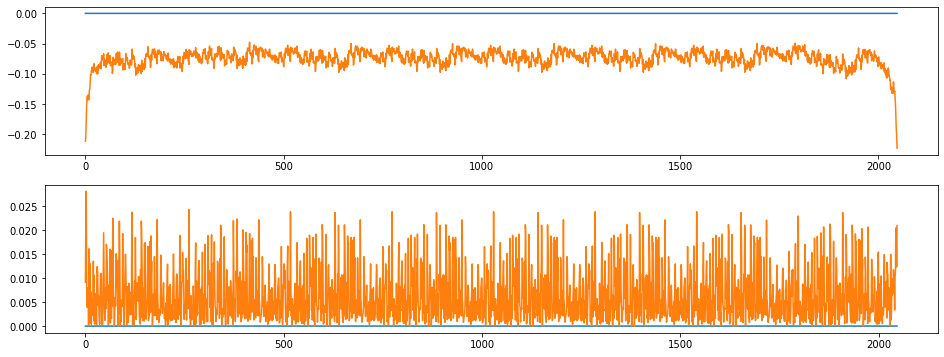

index:  88148
MAE:  0.07442340039415285
n_bunches       1916
bunch_index     2784
bunch_number    1536
Name: 9912029, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170925_21h04m53s.h5


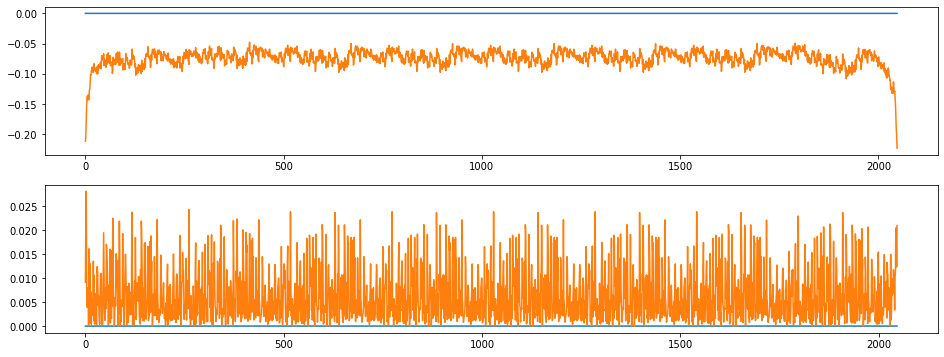

index:  166335
MAE:  0.07442340039415285
n_bunches       2556
bunch_index     1552
bunch_number    1146
Name: 10399679, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7117/instability_data/07117_Inst_B1H_Q7_20180902_06h59m16s.h5


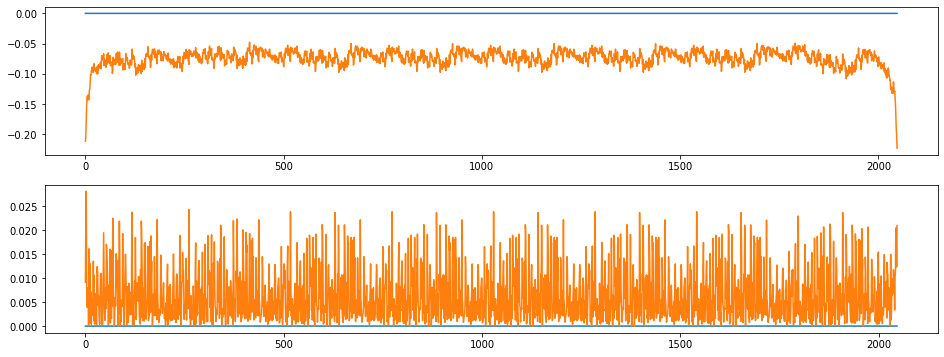

index:  88126
MAE:  0.07442340039415285
n_bunches       228
bunch_index     718
bunch_number     62
Name: 10126666, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6220/instability_data/06220_Inst_B1H_Q7_20170917_22h49m14s.h5


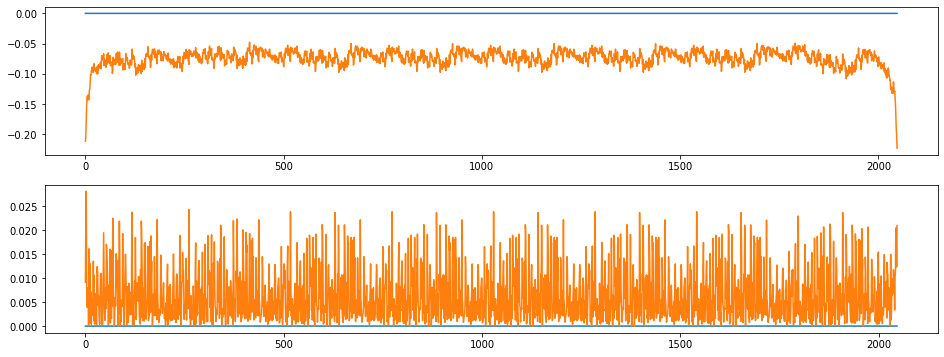

index:  269492
MAE:  0.07442340039415285
n_bunches       1092
bunch_index       79
bunch_number      44
Name: 7430694, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6603/instability_data/06603_Inst_B1H_Q7_20180423_19h49m18s.h5


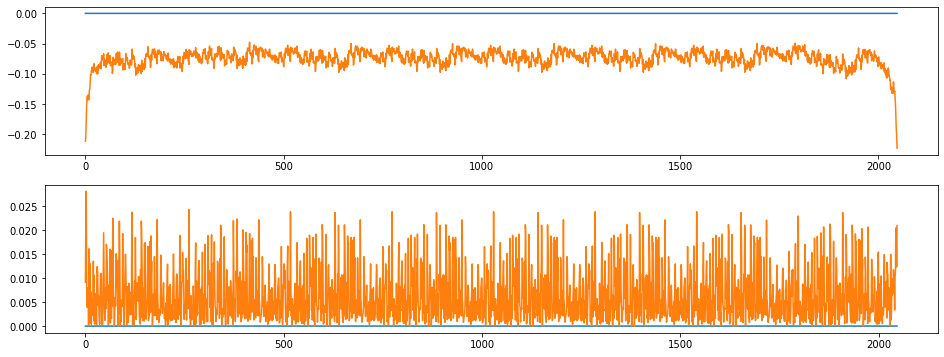

index:  269540
MAE:  0.07442340039415285
n_bunches       300
bunch_index     162
bunch_number    100
Name: 8321322, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6898/instability_data/06898_Inst_B1H_Q7_20180708_00h49m42s.h5


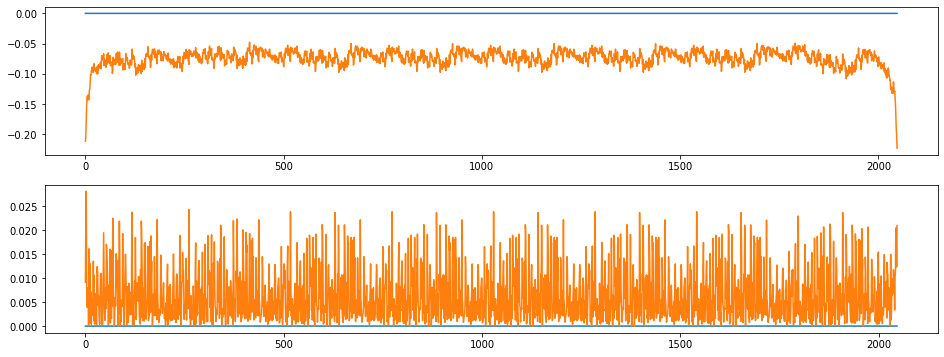

In [29]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Around a point

In [30]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.6))

index:  371157
MAE:  0.600352356264193
n_bunches        732
bunch_index     1017
bunch_number     547
Name: 7707950, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7177/instability_data/07177_Inst_B1H_Q7_20180915_14h40m19s.h5


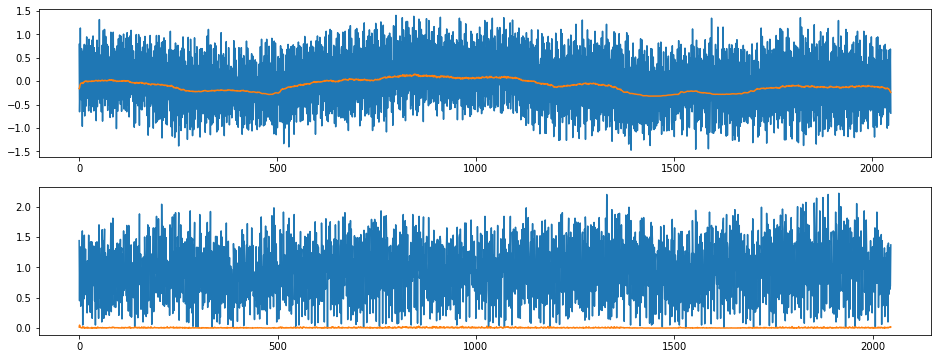

index:  212613
MAE:  0.5995716869941681
n_bunches       748
bunch_index     698
bunch_number    355
Name: 9730292, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6392/instability_data/06392_Inst_B1H_Q7_20171116_05h19m38s.h5


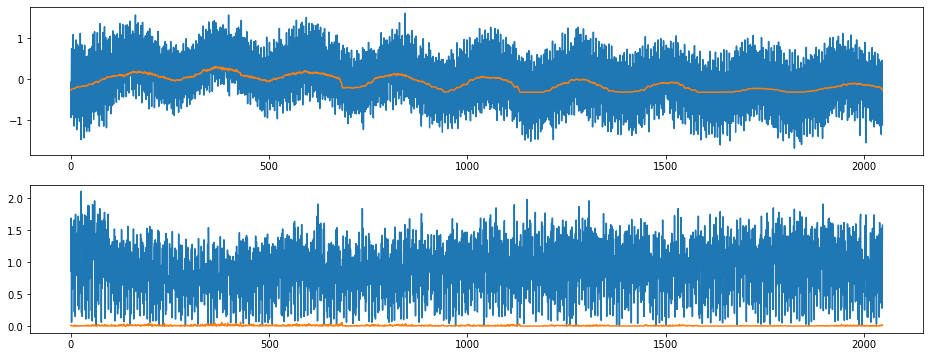

index:  165518
MAE:  0.6005999734968646
n_bunches       2319
bunch_index     1726
bunch_number    1171
Name: 2138776, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6639/instability_data/06639_Inst_B1H_Q7_20180503_16h50m26s.h5


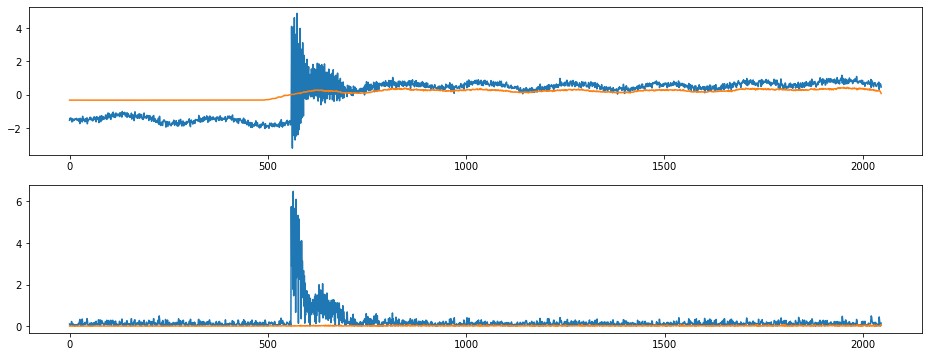

index:  97498
MAE:  0.6006368215469411
n_bunches       780
bunch_index     302
bunch_number    189
Name: 10000570, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6659/instability_data/06659_Inst_B1H_Q7_20180509_00h23m33s.h5


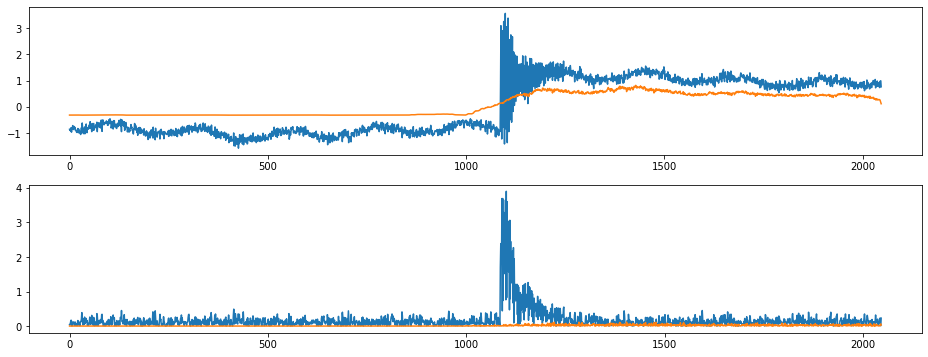

index:  314173
MAE:  0.6008514781144914
n_bunches       2556
bunch_index     1173
bunch_number     838
Name: 7663365, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6659/instability_data/06659_Inst_B1H_Q7_20180509_05h04m16s.h5


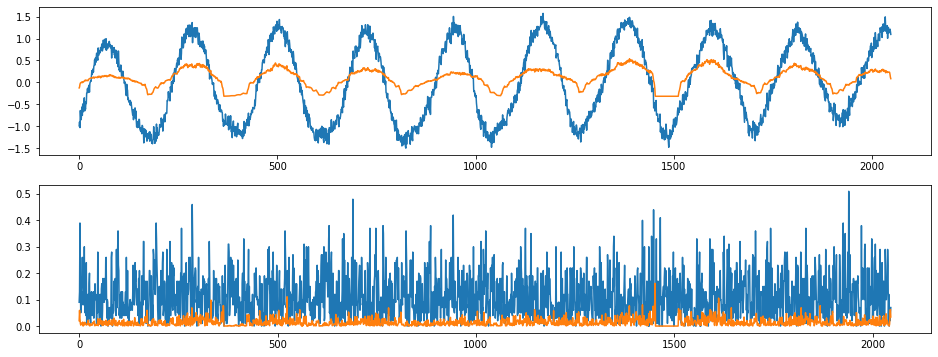

index:  232946
MAE:  0.5987600157631096
n_bunches       1227
bunch_index     1176
bunch_number     433
Name: 5312138, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6858/instability_data/06858_Inst_B1H_Q7_20180628_08h13m28s.h5


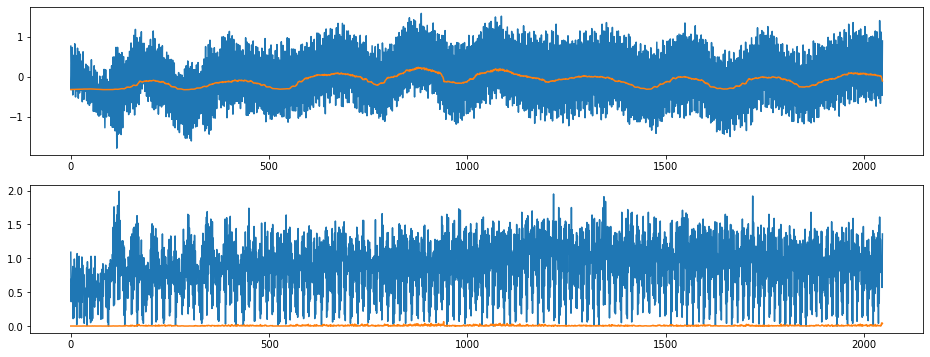

index:  373453
MAE:  0.5986903568624984
n_bunches        908
bunch_index     1027
bunch_number     541
Name: 11461260, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6274/instability_data/06274_Inst_B1H_Q7_20171005_19h04m33s.h5


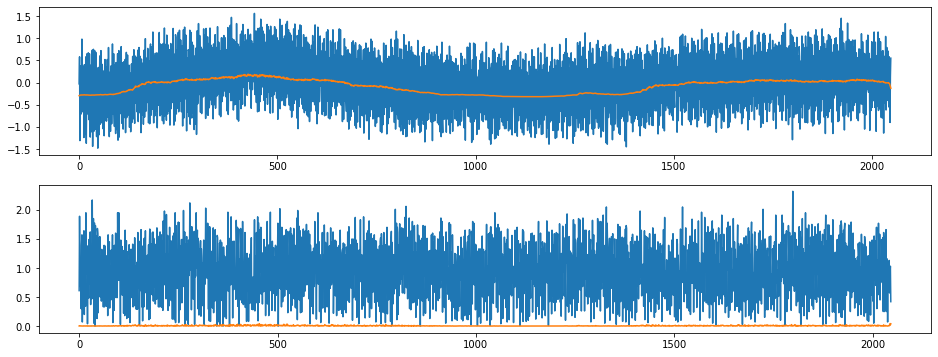

index:  248922
MAE:  0.6014747162433923
n_bunches       540
bunch_index     463
bunch_number    305
Name: 2230759, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6684/instability_data/06684_Inst_B1H_Q7_20180515_06h15m59s.h5


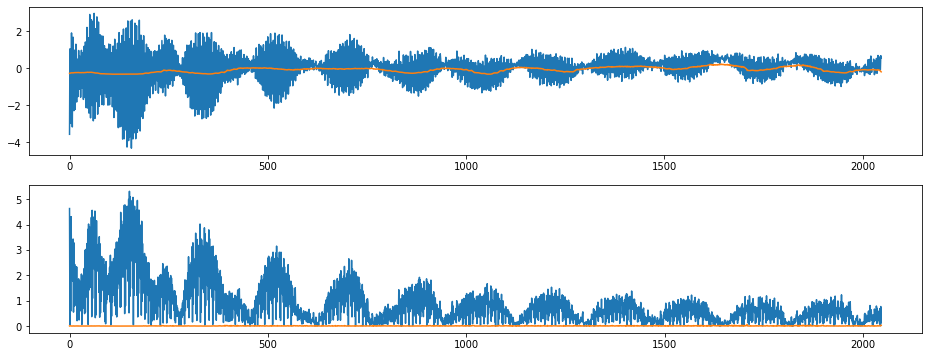

index:  212196
MAE:  0.6020764616082306
n_bunches        733
bunch_index     2213
bunch_number     465
Name: 9261694, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7491/instability_data/07491_Inst_B1H_Q7_20181202_08h45m14s.h5


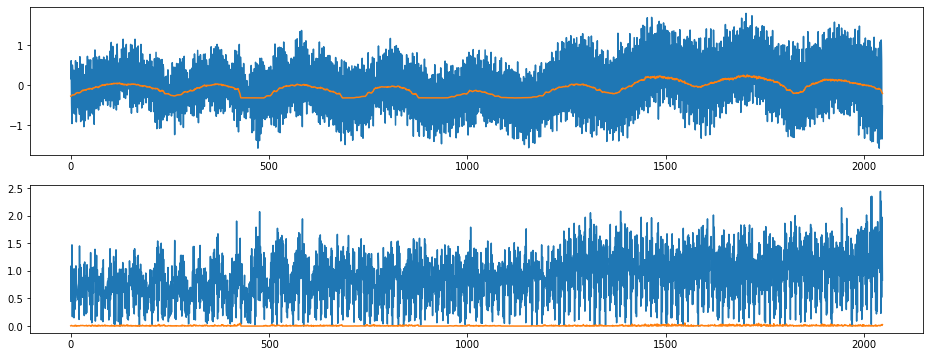

index:  387393
MAE:  0.5978930842736736
n_bunches       1004
bunch_index      238
bunch_number     120
Name: 9612979, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6363/instability_data/06363_Inst_B1H_Q7_20171105_20h57m48s.h5


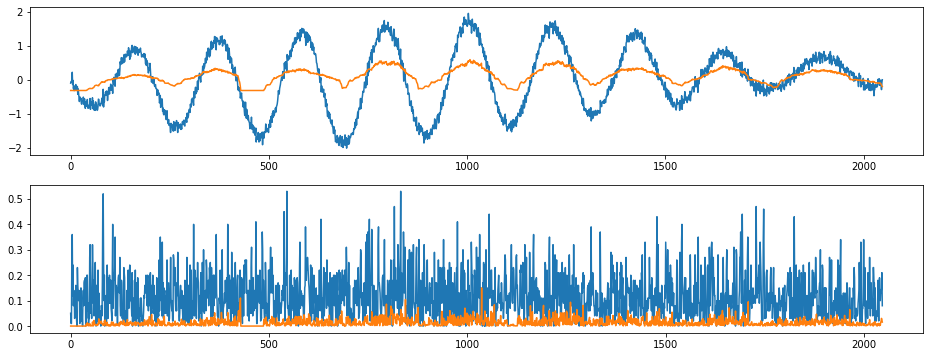

In [31]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [32]:
import keras

In [43]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_3').output)

In [44]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 8, 4])

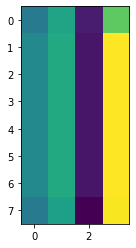

In [45]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  14281
MAE:  0.07442340039415285
n_bunches       1068
bunch_index     1002
bunch_number     731
Name: 9443751, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6918/instability_data/06918_Inst_B1H_Q7_20180713_02h00m18s.h5


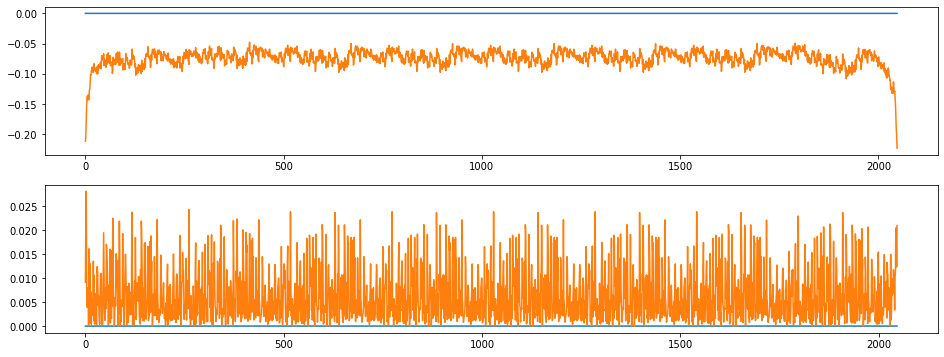

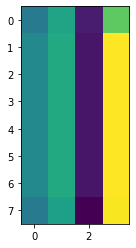

index:  269253
MAE:  0.07442340039415285
n_bunches       796
bunch_index     114
bunch_number     56
Name: 4829296, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h41m05s.h5


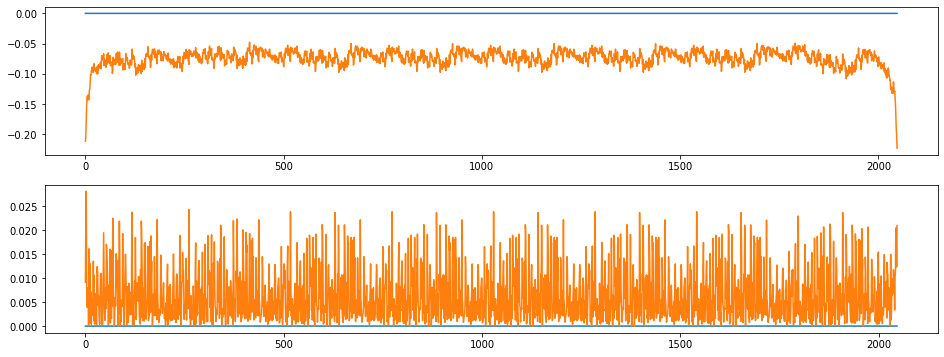

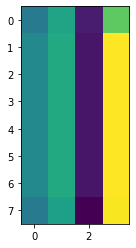

index:  88260
MAE:  0.07442340039415285
n_bunches        987
bunch_index     2385
bunch_number     743
Name: 215784, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6901/instability_data/06901_Inst_B1H_Q7_20180708_04h11m22s.h5


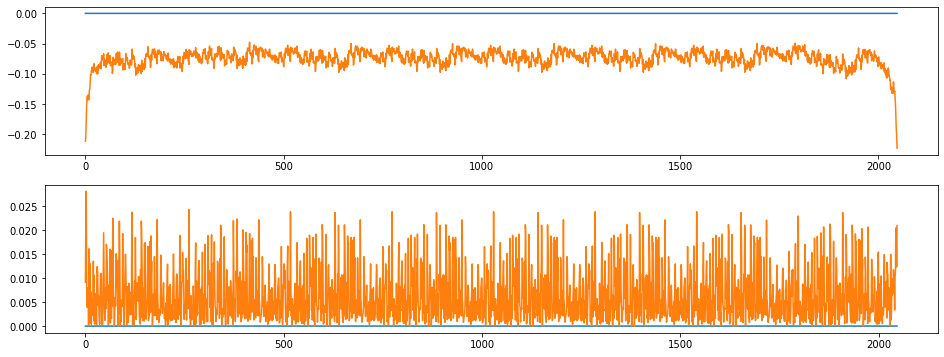

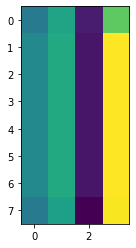

index:  88242
MAE:  0.07442340039415285
n_bunches       636
bunch_index     710
bunch_number    500
Name: 5118314, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6749/instability_data/06749_Inst_B1H_Q7_20180601_03h52m19s.h5


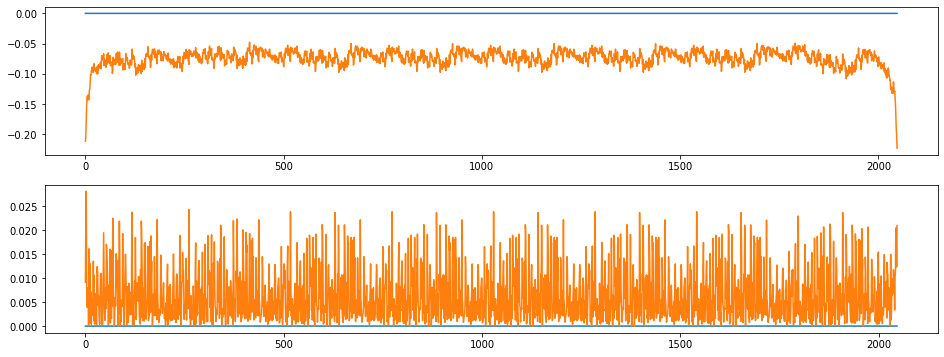

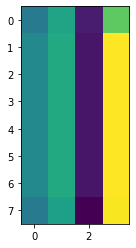

index:  51862
MAE:  0.07442340039415285
n_bunches       588
bunch_index     445
bunch_number    210
Name: 4120617, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6807/instability_data/06807_Inst_B1H_Q7_20180616_03h48m14s.h5


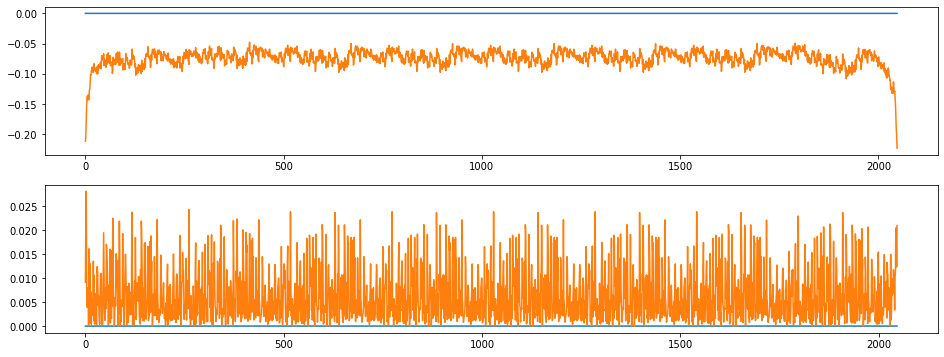

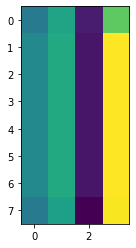

index:  88148
MAE:  0.07442340039415285
n_bunches       1916
bunch_index     2784
bunch_number    1536
Name: 9912029, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170925_21h04m53s.h5


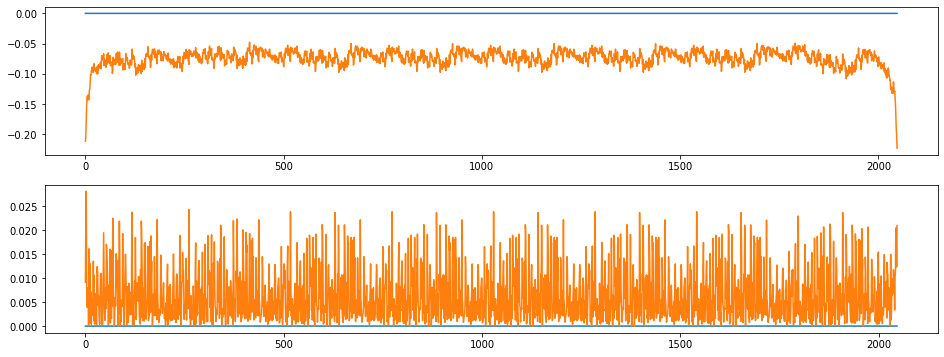

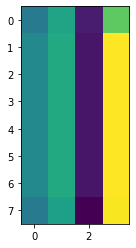

index:  166335
MAE:  0.07442340039415285
n_bunches       2556
bunch_index     1552
bunch_number    1146
Name: 10399679, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7117/instability_data/07117_Inst_B1H_Q7_20180902_06h59m16s.h5


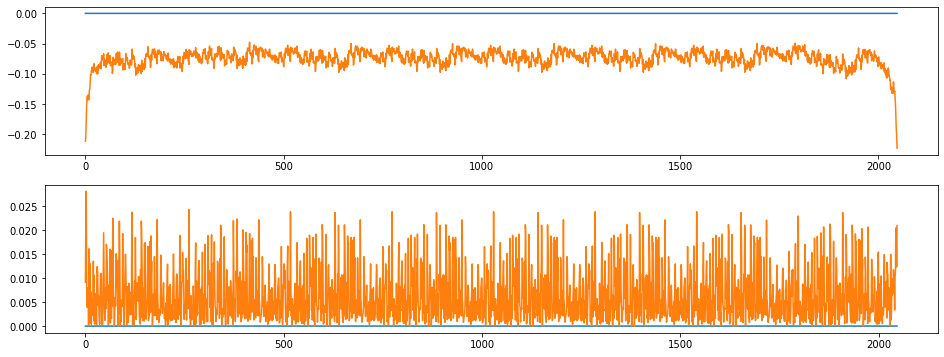

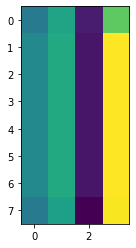

index:  88126
MAE:  0.07442340039415285
n_bunches       228
bunch_index     718
bunch_number     62
Name: 10126666, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6220/instability_data/06220_Inst_B1H_Q7_20170917_22h49m14s.h5


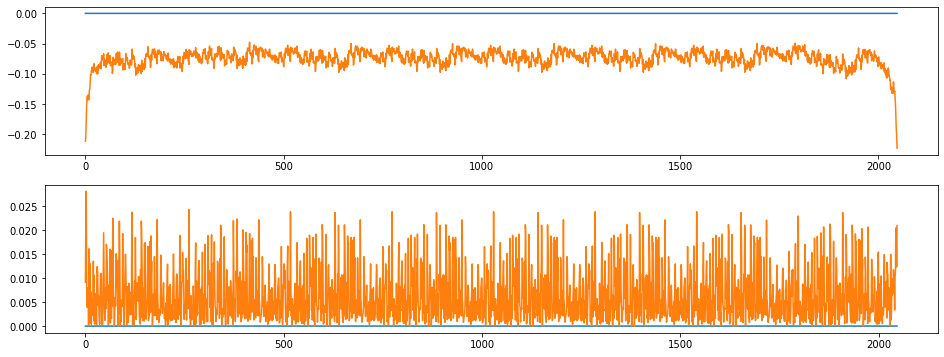

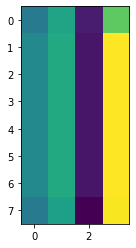

index:  269492
MAE:  0.07442340039415285
n_bunches       1092
bunch_index       79
bunch_number      44
Name: 7430694, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6603/instability_data/06603_Inst_B1H_Q7_20180423_19h49m18s.h5


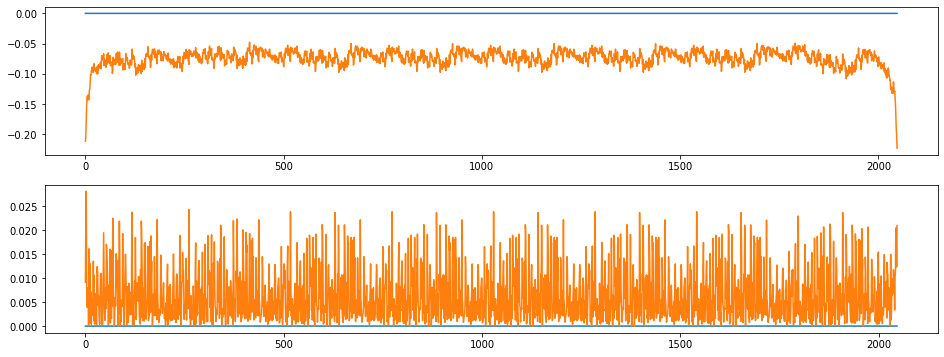

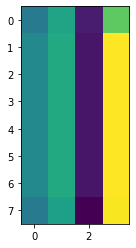

index:  269540
MAE:  0.07442340039415285
n_bunches       300
bunch_index     162
bunch_number    100
Name: 8321322, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6898/instability_data/06898_Inst_B1H_Q7_20180708_00h49m42s.h5


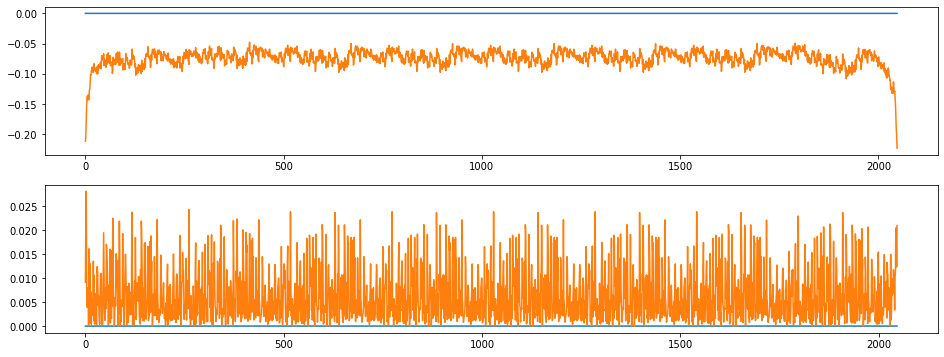

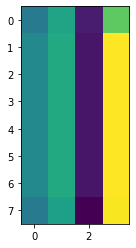

In [46]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  269528
MAE:  13.12158100922592
n_bunches       2175
bunch_index      145
bunch_number      83
Name: 9982559, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_14h34m14s.h5


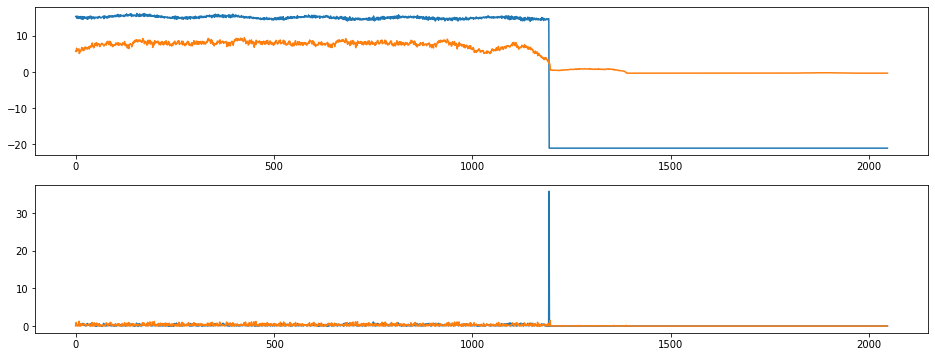

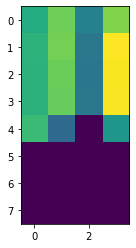

index:  259166
MAE:  12.643158903981966
n_bunches        987
bunch_index     3129
bunch_number     848
Name: 8437044, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h26m14s.h5


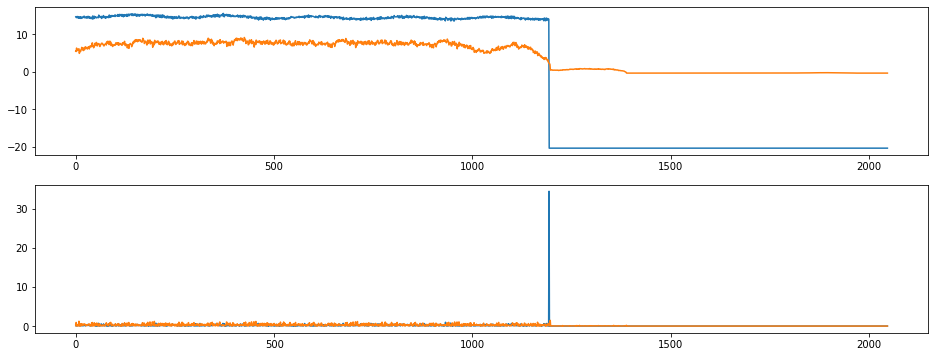

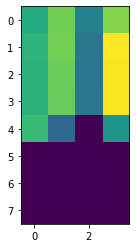

index:  243619
MAE:  12.637404030905746
n_bunches       1836
bunch_index      357
bunch_number     184
Name: 4782102, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_12h27m14s.h5


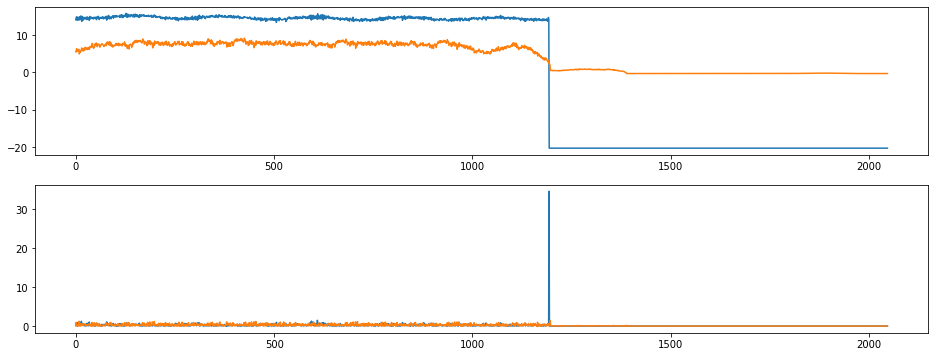

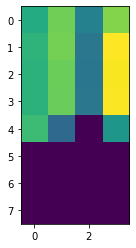

index:  108393
MAE:  12.127495713512761
n_bunches       670
bunch_index     297
bunch_number     60
Name: 3411356, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181123_01h57m14s.h5


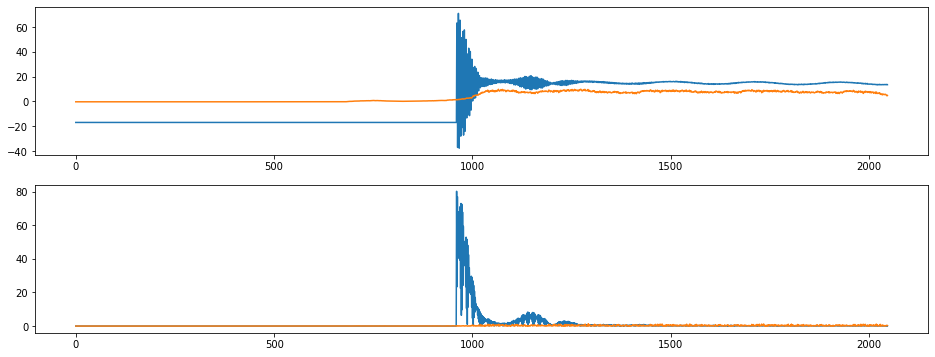

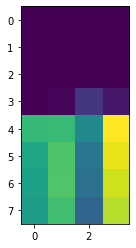

index:  375550
MAE:  10.665928978757002
n_bunches        339
bunch_index     1983
bunch_number     221
Name: 2707765, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6594/instability_data/06594_Inst_B1H_Q7_20180422_12h42m14s.h5


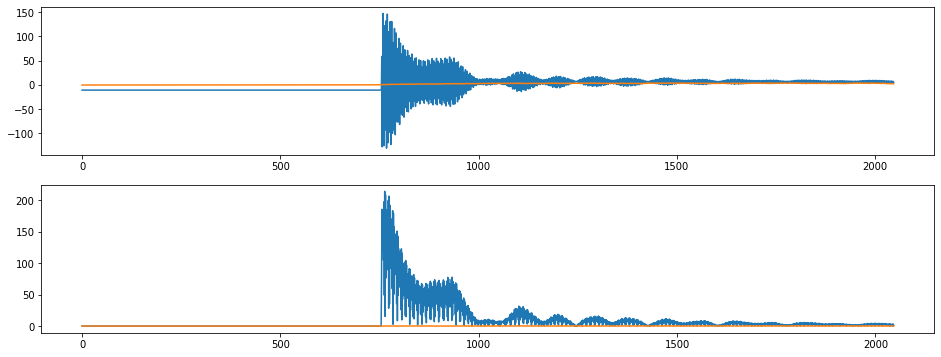

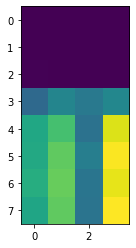

index:  142396
MAE:  10.050678652048225
n_bunches       2556
bunch_index     1739
bunch_number    1265
Name: 4486517, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_16h14m13s.h5


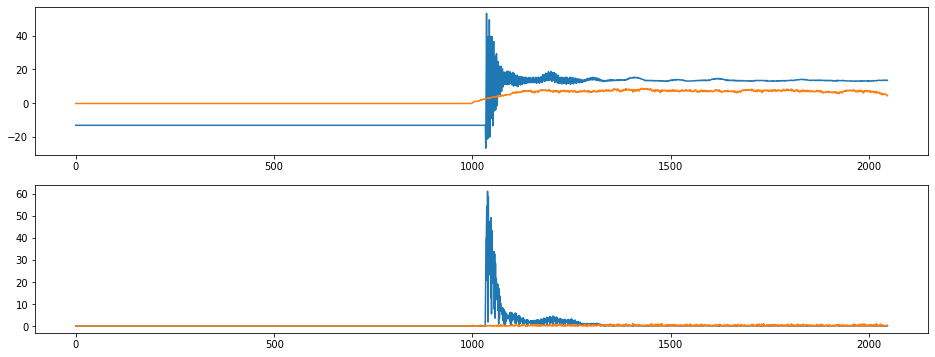

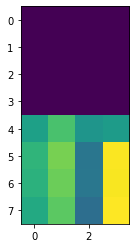

index:  85943
MAE:  9.349371561761654
n_bunches       924
bunch_index     688
bunch_number    497
Name: 4509005, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7270/instability_data/07270_Inst_B1H_Q7_20181009_00h01m14s.h5


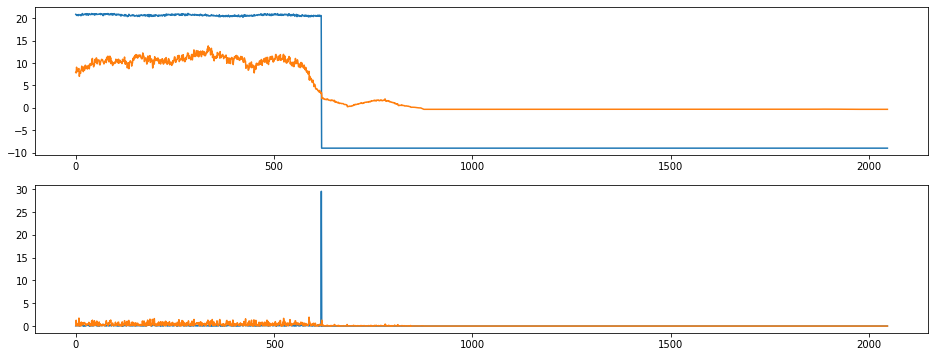

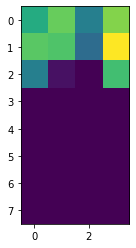

index:  194059
MAE:  9.32827551486931
n_bunches       276
bunch_index     328
bunch_number    137
Name: 6247712, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7366/instability_data/07366_Inst_B1H_Q7_20181027_02h23m59s.h5


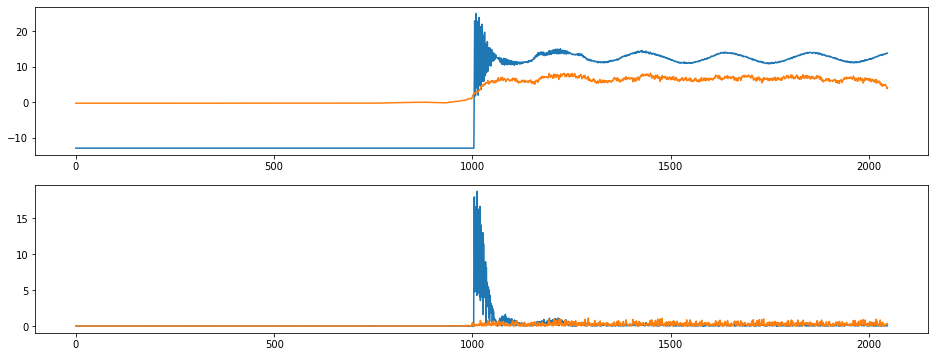

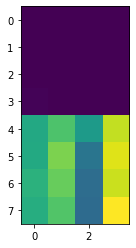

index:  250521
MAE:  8.586611178891037
n_bunches        152
bunch_index     2220
bunch_number      97
Name: 304460, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7299/instability_data/07299_Inst_B1H_Q7_20181014_04h31m14s.h5


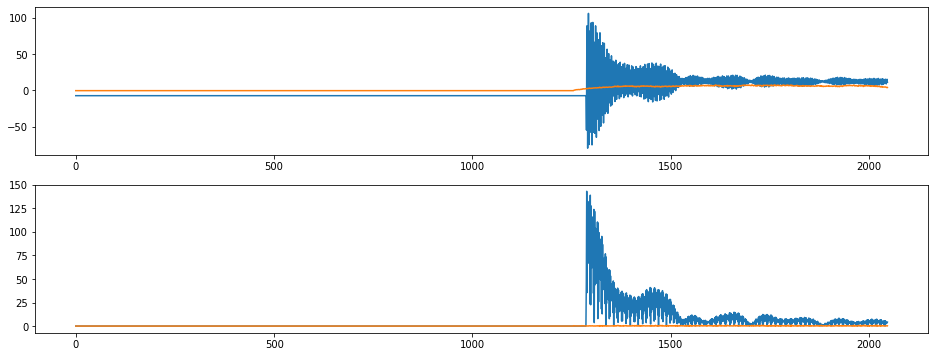

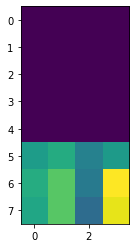

index:  407490
MAE:  8.025864824847377
n_bunches       2556
bunch_index     3330
bunch_number    2480
Name: 6867955, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7135/instability_data/07135_Inst_B1H_Q7_20180907_23h18m14s.h5


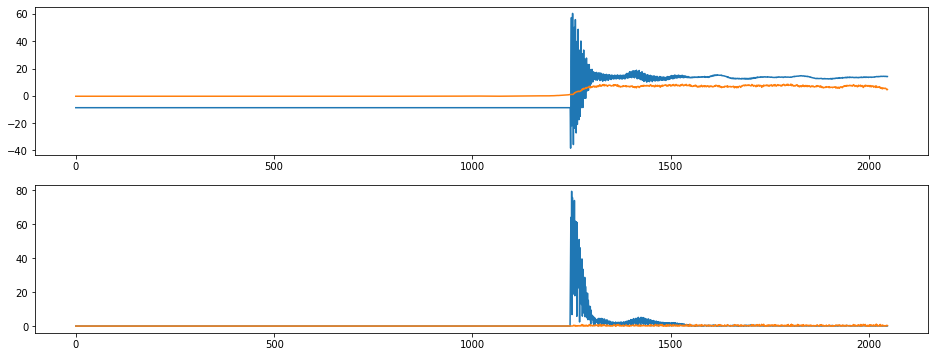

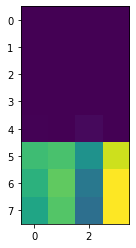

index:  296261
MAE:  8.024032639035722
n_bunches       540
bunch_index     596
bunch_number    419
Name: 9669280, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7328/instability_data/07328_Inst_B1H_Q7_20181021_21h55m49s.h5


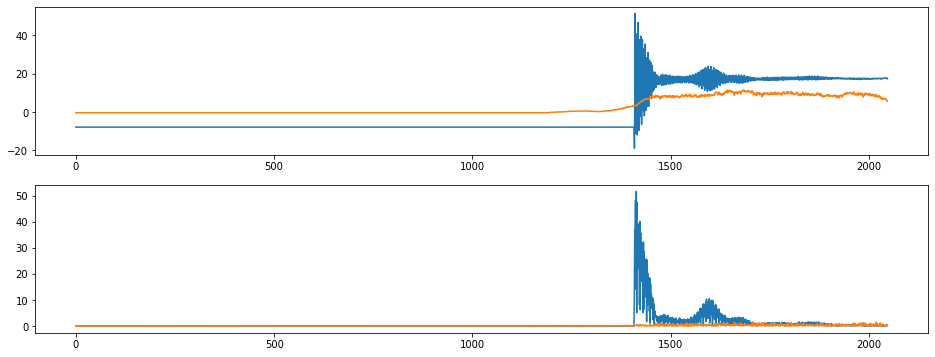

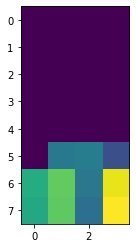

index:  205748
MAE:  7.775535923910505
n_bunches       1068
bunch_index     1163
bunch_number     847
Name: 6413992, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7080/instability_data/07080_Inst_B1H_Q7_20180823_22h07m32s.h5


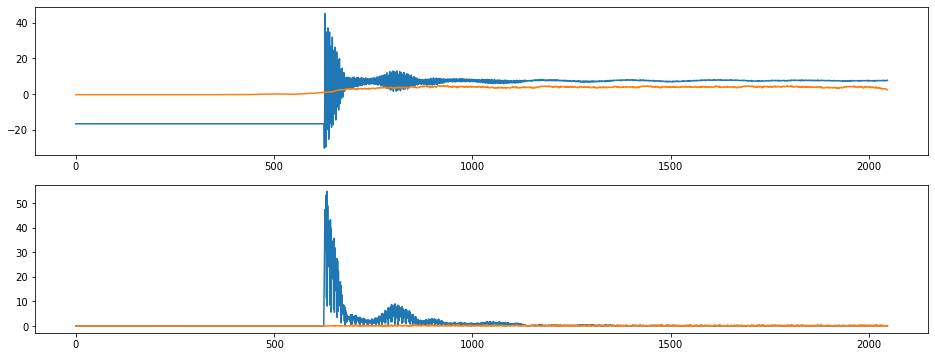

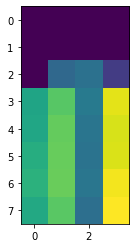

index:  368050
MAE:  7.769865387679021
n_bunches       372
bunch_index       0
bunch_number      0
Name: 5475118, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7447/instability_data/07447_Inst_B1H_Q7_20181116_04h59m18s.h5


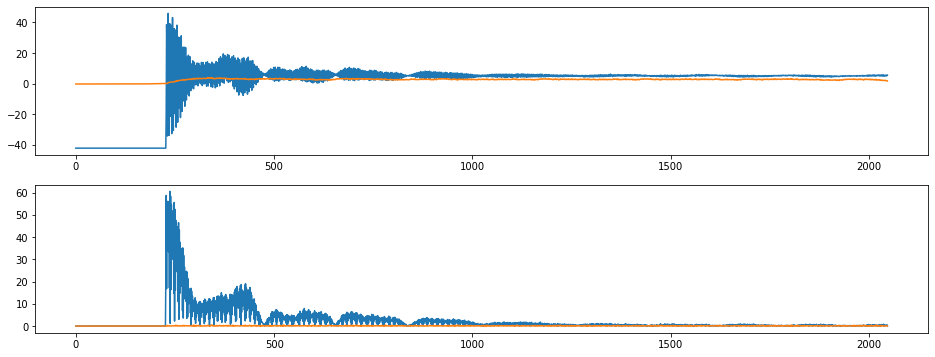

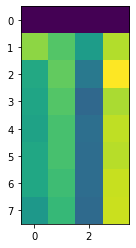

index:  264827
MAE:  7.722143649005447
n_bunches        924
bunch_index     1252
bunch_number     910
Name: 10728079, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6707/instability_data/06707_Inst_B1H_Q7_20180520_14h34m08s.h5


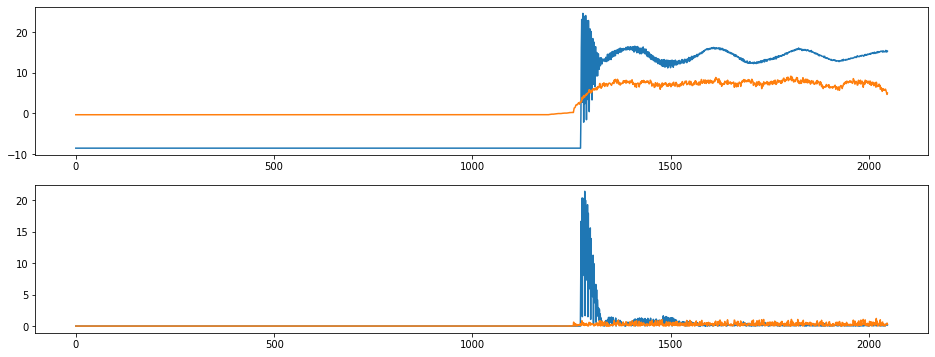

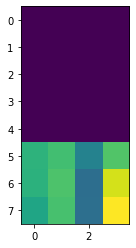

index:  376179
MAE:  7.454523688608315
n_bunches       1868
bunch_index      634
bunch_number     339
Name: 309880, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6355/instability_data/06355_Inst_B1H_Q7_20171101_19h27m14s.h5


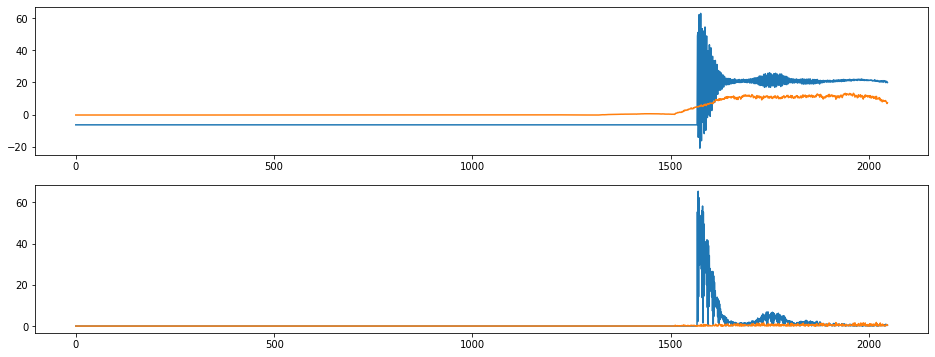

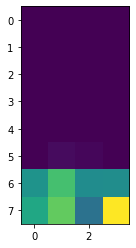

index:  219975
MAE:  7.398291551376169
n_bunches       408
bunch_index     996
bunch_number    182
Name: 6748551, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7452/instability_data/07452_Inst_B1H_Q7_20181117_16h18m14s.h5


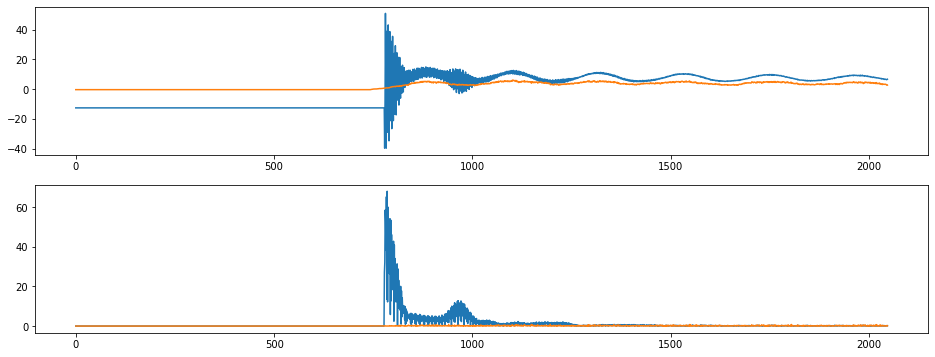

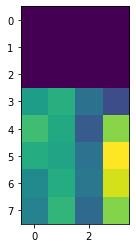

index:  268402
MAE:  7.189278114117334
n_bunches        733
bunch_index     2704
bunch_number     567
Name: 8148203, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7487/instability_data/07487_Inst_B1H_Q7_20181130_23h00m17s.h5


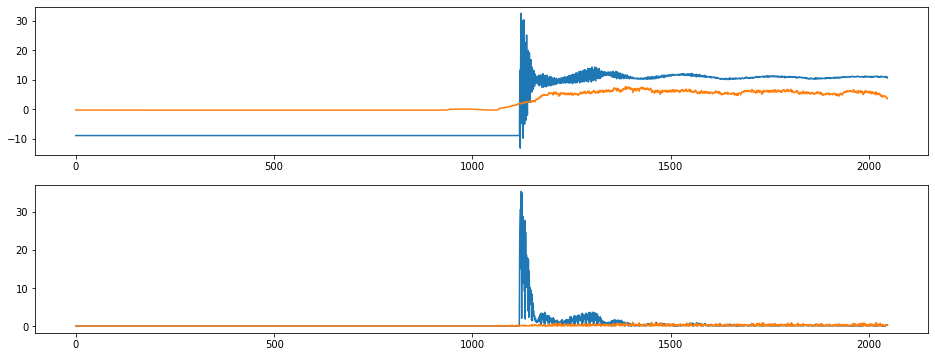

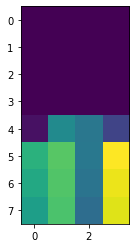

index:  149127
MAE:  7.124163361664688
n_bunches       780
bunch_index     408
bunch_number    276
Name: 2928780, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7242/instability_data/07242_Inst_B1H_Q7_20181001_08h29m16s.h5


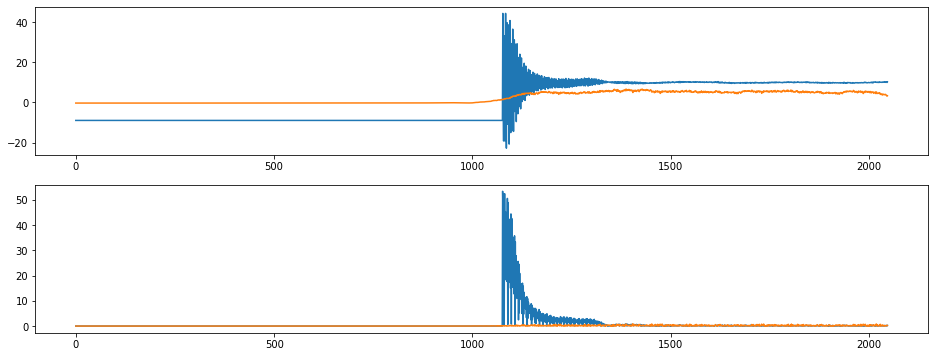

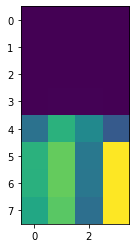

index:  31292
MAE:  7.10021434983646
n_bunches        224
bunch_index     2816
bunch_number     183
Name: 713560, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6194/instability_data/06194_Inst_B1H_Q7_20170913_10h45m14s.h5


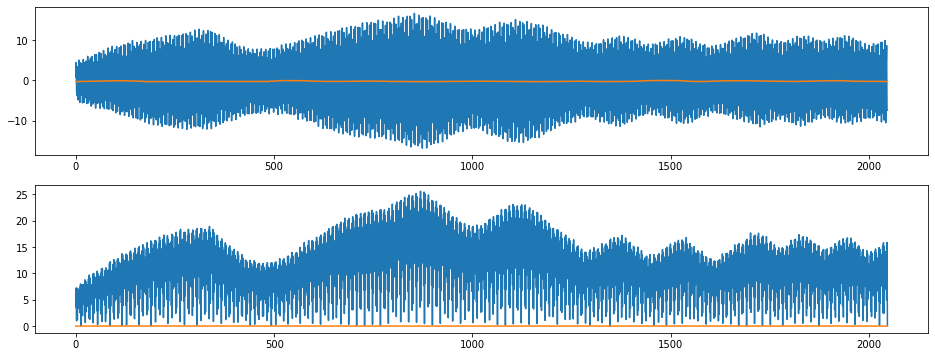

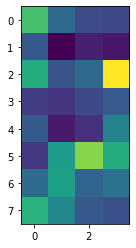

index:  252431
MAE:  7.093144619580415
n_bunches       1868
bunch_index      225
bunch_number     111
Name: 2207433, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6279/instability_data/06279_Inst_B1H_Q7_20171007_12h27m14s.h5


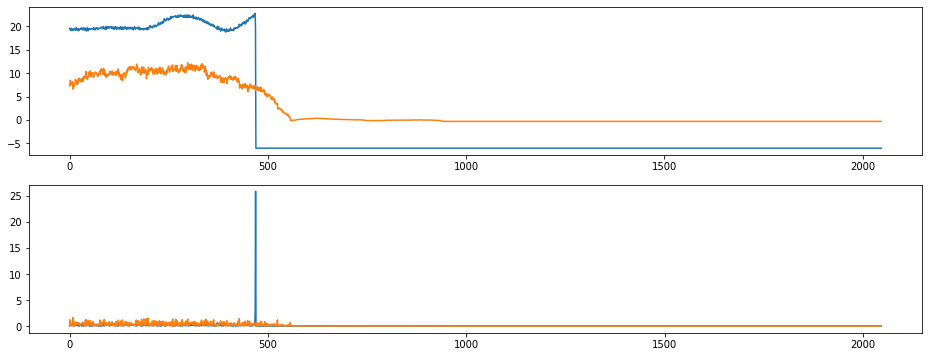

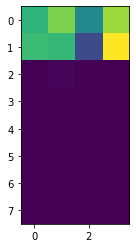

index:  13153
MAE:  7.0373338217008845
n_bunches       2556
bunch_index     1211
bunch_number     888
Name: 11117948, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7031/instability_data/07031_Inst_B1H_Q7_20180806_19h32m14s.h5


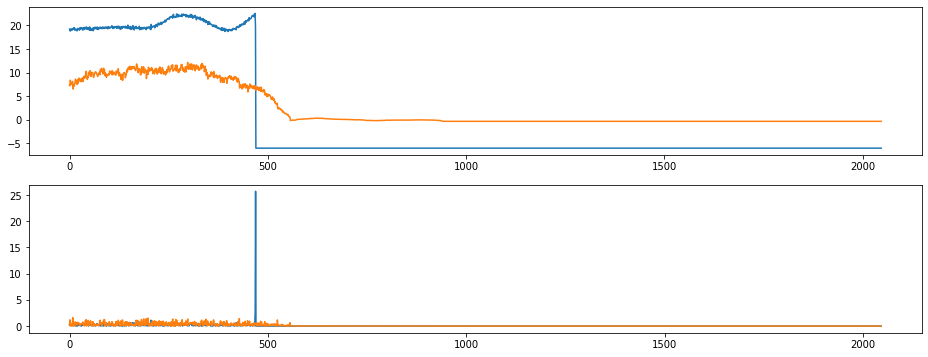

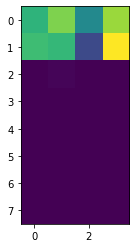

index:  93275
MAE:  6.9851095967990116
n_bunches        908
bunch_index     1576
bunch_number     870
Name: 2128264, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6183/instability_data/06183_Inst_B1H_Q7_20170909_20h12m13s.h5


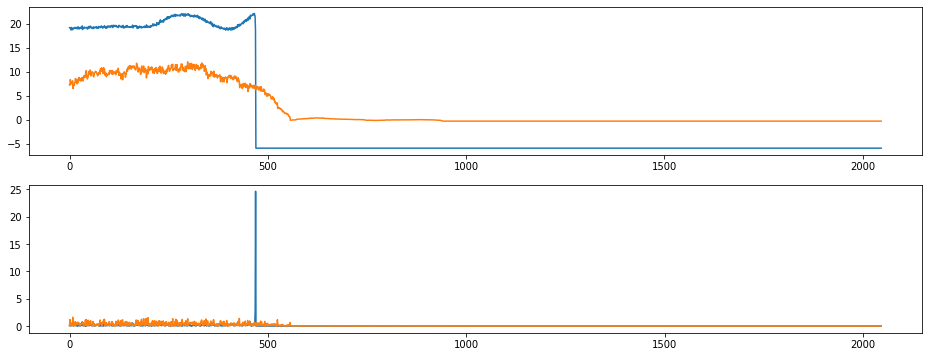

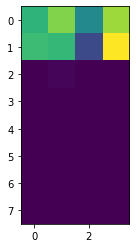

index:  380436
MAE:  6.827936664526058
n_bunches       314
bunch_index     351
bunch_number     88
Name: 9641848, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6613/instability_data/06613_Inst_B1H_Q7_20180426_00h32m15s.h5


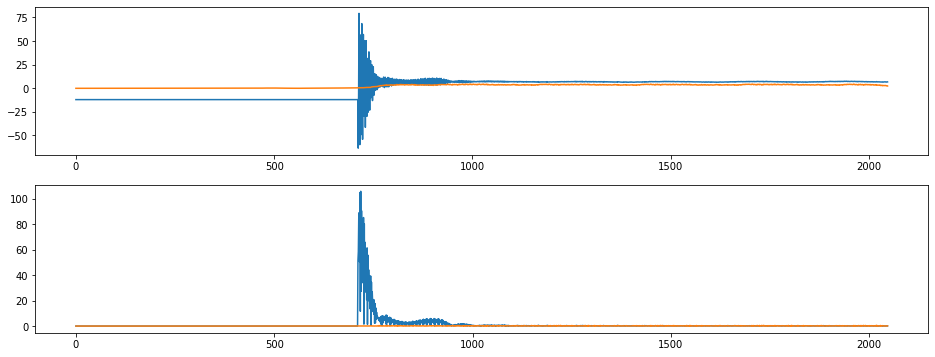

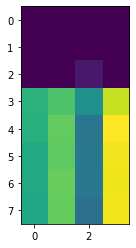

index:  61217
MAE:  6.771471076441229
n_bunches       540
bunch_index     137
bunch_number     75
Name: 3265101, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6641/instability_data/06641_Inst_B1H_Q7_20180504_20h27m55s.h5


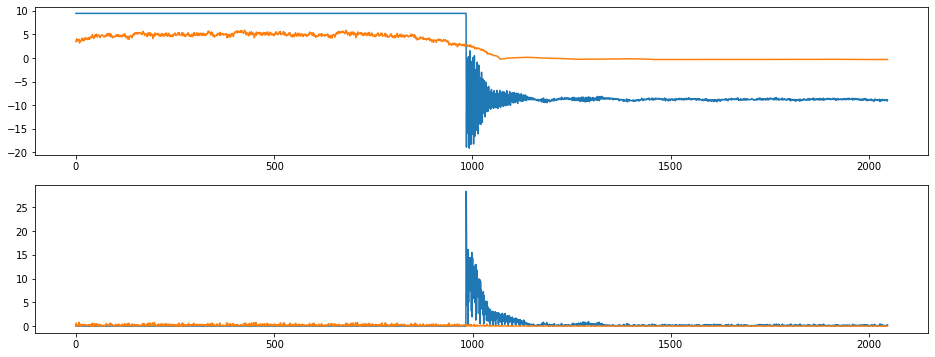

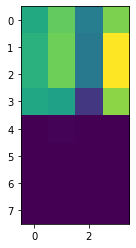

index:  167759
MAE:  6.61647812987503
n_bunches       252
bunch_index     346
bunch_number    245
Name: 6599430, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7110/instability_data/07110_Inst_B1H_Q7_20180831_21h56m26s.h5


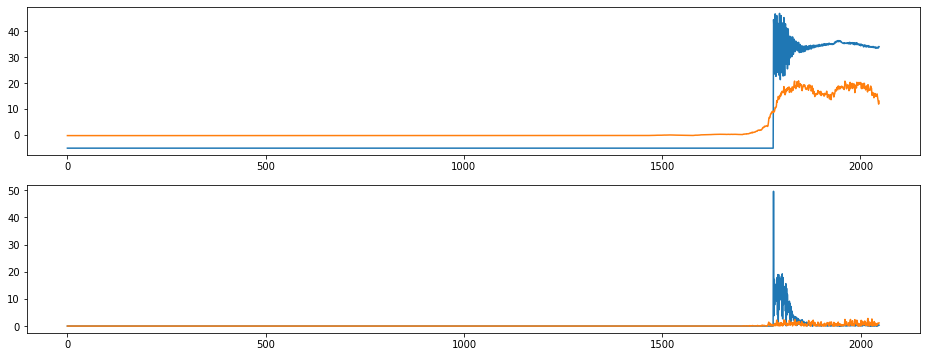

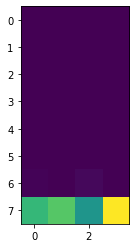

index:  302926
MAE:  6.5709129845260765
n_bunches       782
bunch_index     370
bunch_number    211
Name: 6197276, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180430_20h10m43s.h5


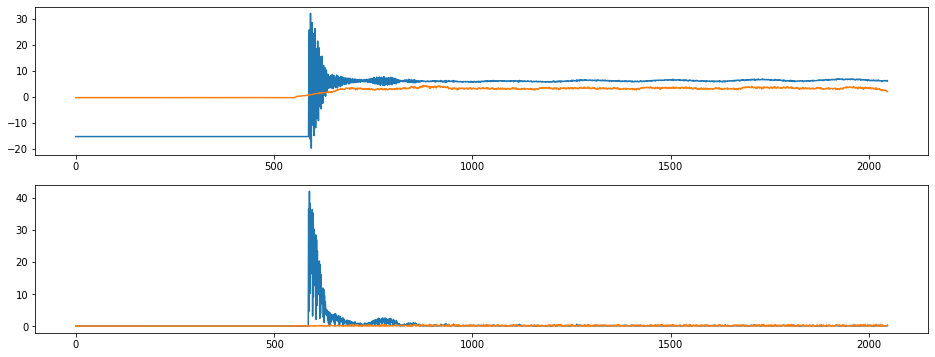

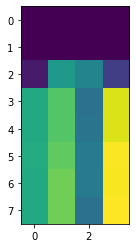

index:  71612
MAE:  6.536861475309124
n_bunches       636
bunch_index     690
bunch_number    499
Name: 7171029, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7325/instability_data/07325_Inst_B1H_Q7_20181021_19h01m15s.h5


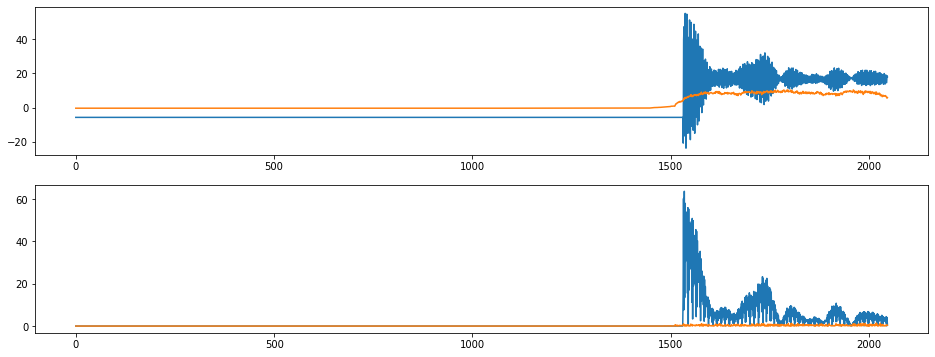

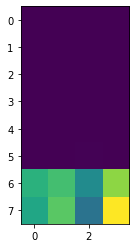

index:  92963
MAE:  6.4897889629888255
n_bunches       1452
bunch_index      776
bunch_number     314
Name: 4422677, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180706_10h43m14s.h5


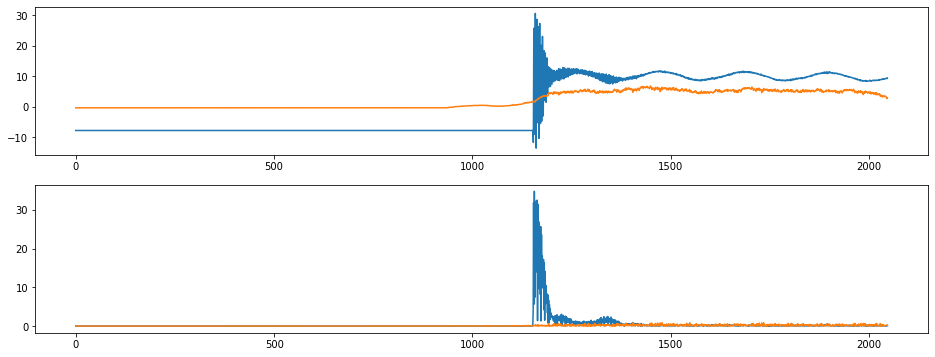

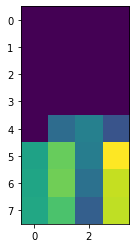

index:  202011
MAE:  6.487320940339998
n_bunches       2556
bunch_index     2287
bunch_number    1697
Name: 796346, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7052/instability_data/07052_Inst_B1H_Q7_20180813_21h55m15s.h5


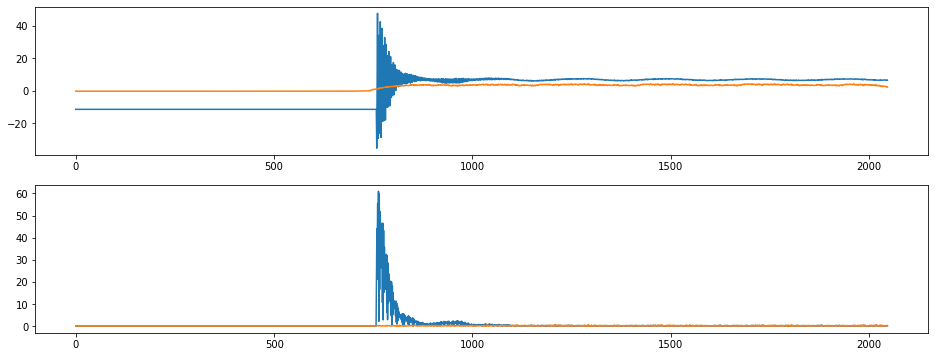

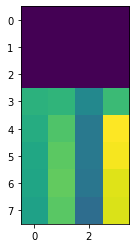

index:  343356
MAE:  6.267929941687326
n_bunches       636
bunch_index     499
bunch_number    341
Name: 5064352, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6672/instability_data/06672_Inst_B1H_Q7_20180511_17h45m01s.h5


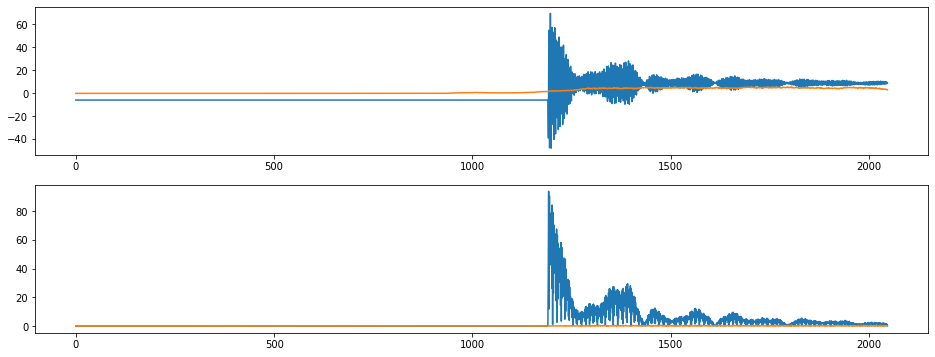

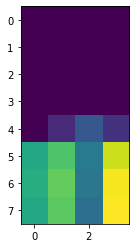

index:  255474
MAE:  6.234222482129118
n_bunches        781
bunch_index     1188
bunch_number     534
Name: 844893, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6686/instability_data/06686_Inst_B1H_Q7_20180515_12h33m33s.h5


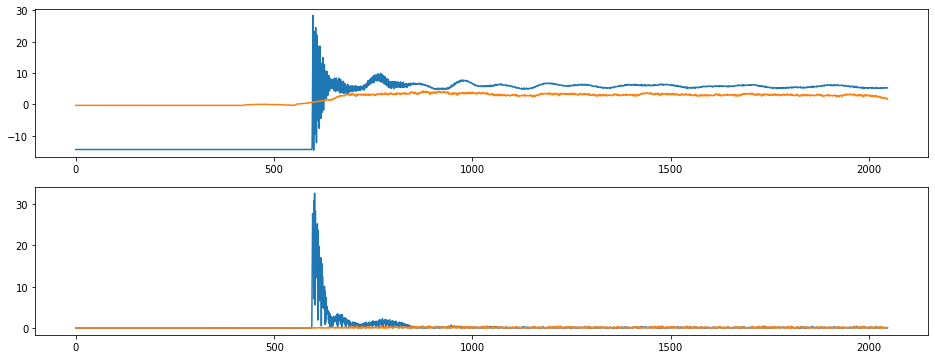

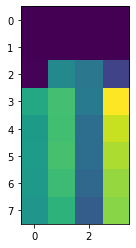

index:  283506
MAE:  6.224509196815487
n_bunches        315
bunch_index     2225
bunch_number     230
Name: 4874337, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6611/instability_data/06611_Inst_B1H_Q7_20180425_09h08m14s.h5


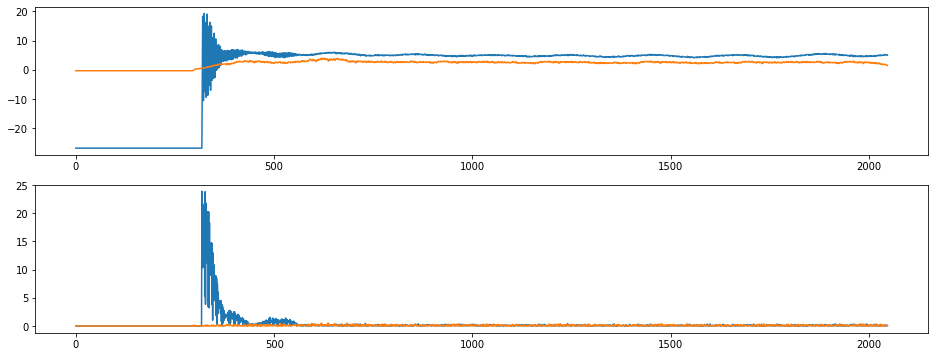

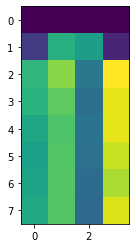

index:  235270
MAE:  6.1928041574839146
n_bunches        300
bunch_index     1352
bunch_number     172
Name: 7090520, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7392/instability_data/07392_Inst_B1H_Q7_20181030_20h55m15s.h5


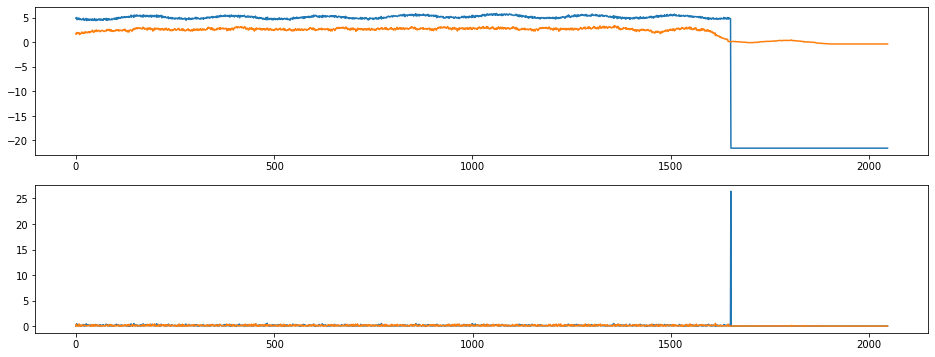

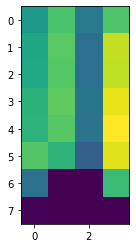

index:  246961
MAE:  6.188713865203317
n_bunches        924
bunch_index     1065
bunch_number     768
Name: 7277185, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6733/instability_data/06733_Inst_B1H_Q7_20180528_04h27m14s.h5


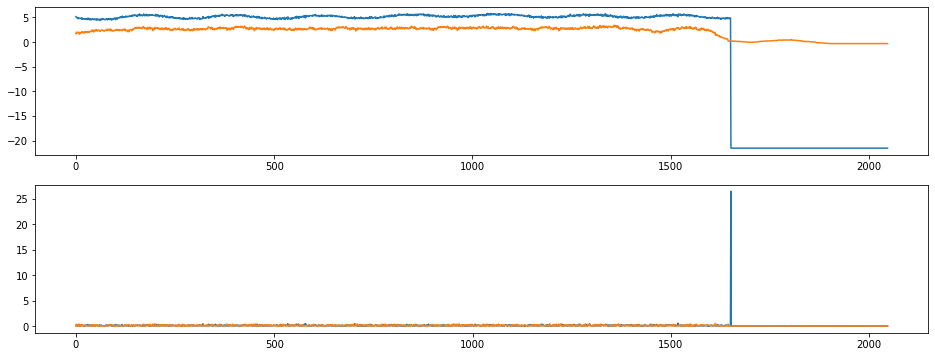

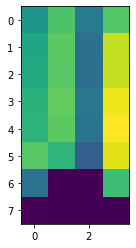

index:  386338
MAE:  6.1768234161299205
n_bunches       908
bunch_index     362
bunch_number    182
Name: 4913494, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6341/instability_data/06341_Inst_B1H_Q7_20171028_00h05m05s.h5


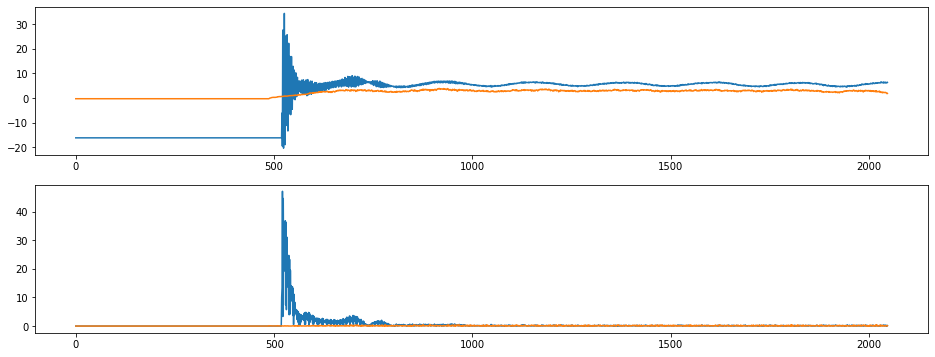

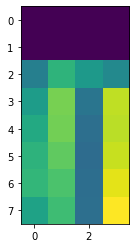

index:  267722
MAE:  6.174206627763342
n_bunches       780
bunch_index     932
bunch_number    649
Name: 10305115, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6738/instability_data/06738_Inst_B1H_Q7_20180529_00h08m24s.h5


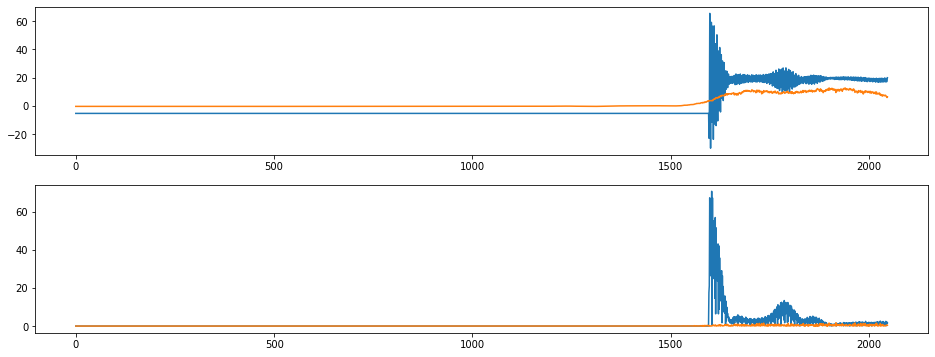

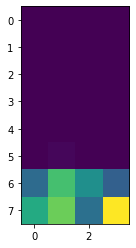

index:  25322
MAE:  6.120889923779759
n_bunches        924
bunch_index     1223
bunch_number     900
Name: 1729659, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6956/instability_data/06956_Inst_B1H_Q7_20180721_09h13m58s.h5


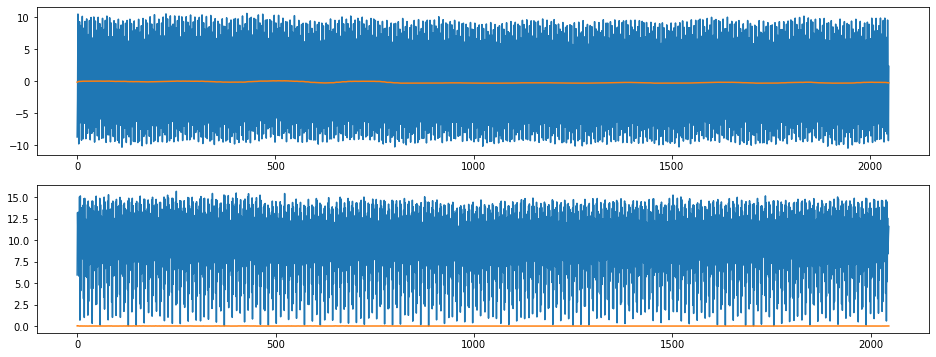

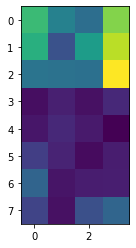

index:  27456
MAE:  6.1106810750826845
n_bunches       780
bunch_index     105
bunch_number     37
Name: 11219672, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6737/instability_data/06737_Inst_B1H_Q7_20180528_21h36m14s.h5


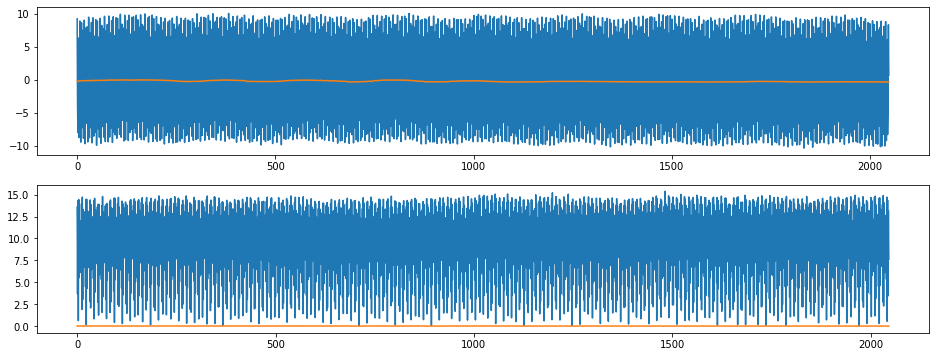

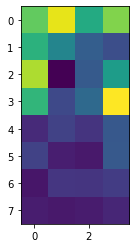

index:  196466
MAE:  6.099033890380816
n_bunches       924
bunch_index     346
bunch_number    245
Name: 4516897, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7048/instability_data/07048_Inst_B1H_Q7_20180813_04h40m54s.h5


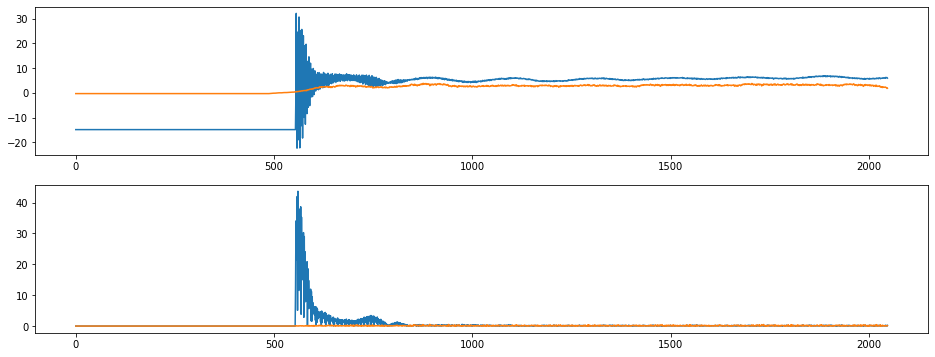

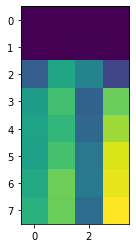

index:  30555
MAE:  6.096732746318157
n_bunches        987
bunch_index     1421
bunch_number     439
Name: 1514709, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6688/instability_data/06688_Inst_B1H_Q7_20180515_19h06m14s.h5


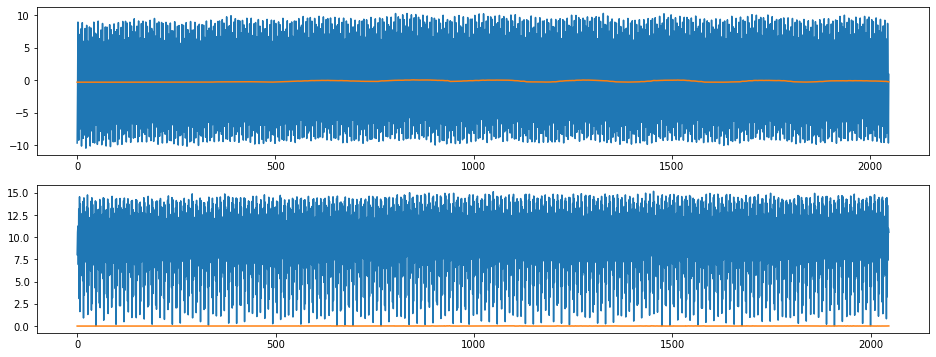

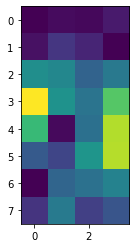

index:  32648
MAE:  6.087750862390385
n_bunches       924
bunch_index     920
bunch_number    637
Name: 6423890, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180520_21h01m14s.h5


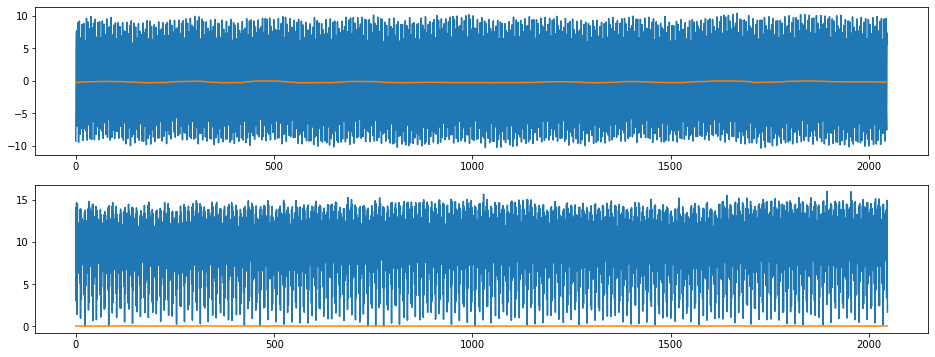

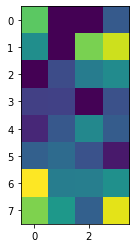

index:  32095
MAE:  6.05381885415758
n_bunches        362
bunch_index     1349
bunch_number     306
Name: 8502989, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6614/instability_data/06614_Inst_B1H_Q7_20180426_02h57m14s.h5


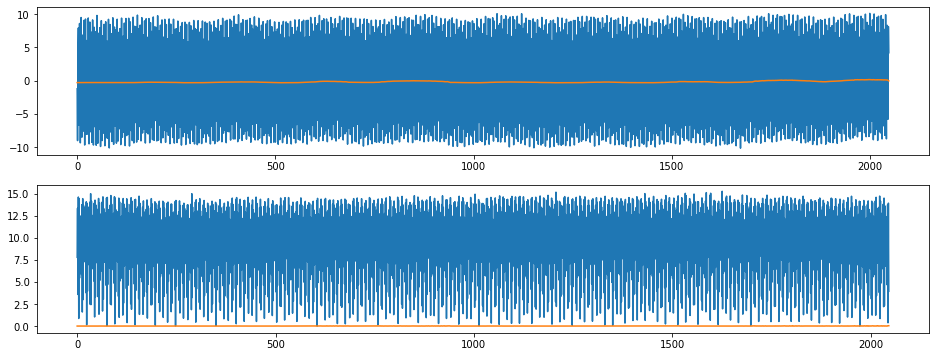

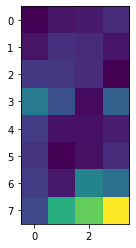

index:  381514
MAE:  6.010252498014015
n_bunches       1868
bunch_index     2733
bunch_number    1466
Name: 6774655, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6276/instability_data/06276_Inst_B1H_Q7_20171006_17h34m14s.h5


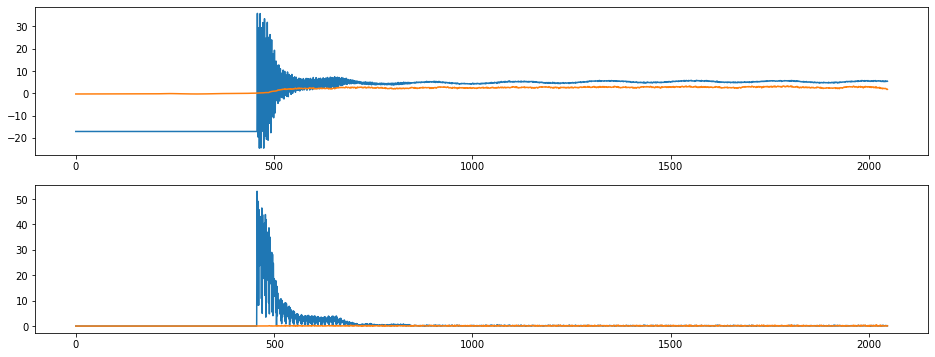

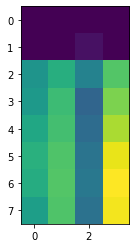

index:  100127
MAE:  6.005373303906526
n_bunches        560
bunch_index     1885
bunch_number     344
Name: 8719997, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7443/instability_data/07443_Inst_B1H_Q7_20181114_16h18m29s.h5


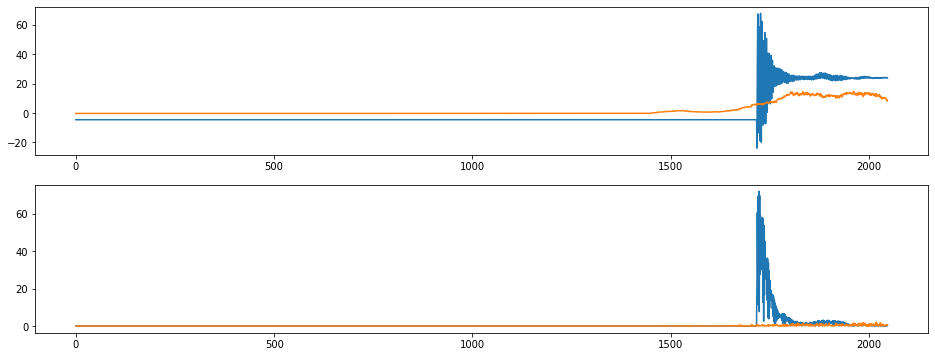

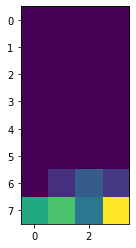

index:  25398
MAE:  5.955094253393764
n_bunches       2555
bunch_index      628
bunch_number     444
Name: 566794, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7137/instability_data/07137_Inst_B1H_Q7_20180908_15h14m11s.h5


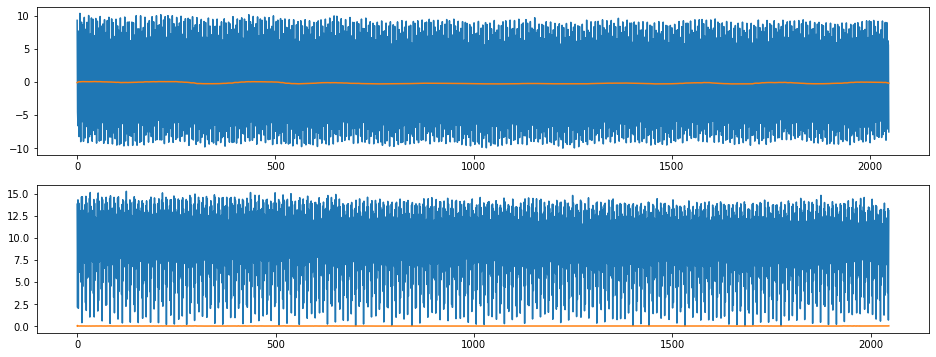

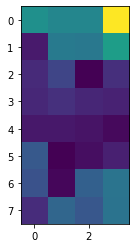

index:  26207
MAE:  5.9495328010624515
n_bunches       1916
bunch_index     2971
bunch_number    1641
Name: 1485449, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170930_00h40m33s.h5


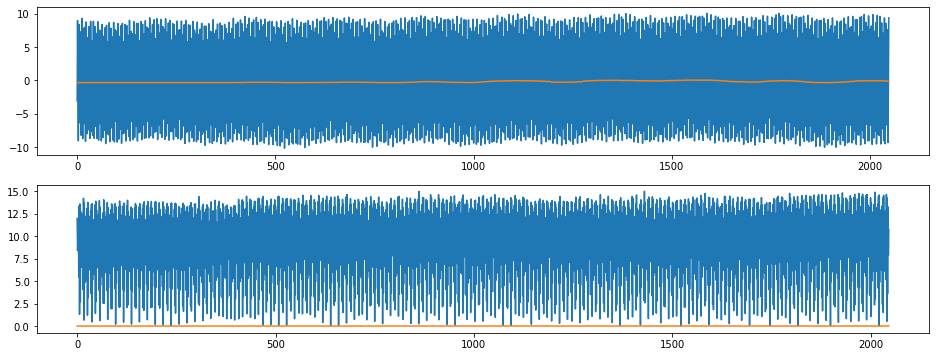

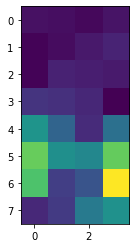

index:  135904
MAE:  5.939941703662625
n_bunches       1076
bunch_index      220
bunch_number      85
Name: 3673410, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6170/instability_data/06170_Inst_B1H_Q7_20170905_19h51m09s.h5


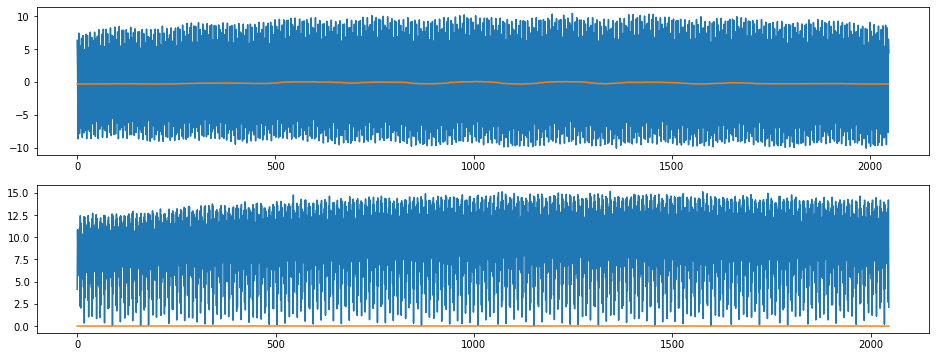

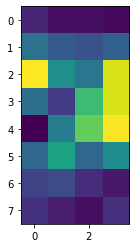

index:  233157
MAE:  5.843873963111255
n_bunches       108
bunch_index     100
bunch_number     51
Name: 7628262, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7058/instability_data/07058_Inst_B1H_Q7_20180817_05h19m16s.h5


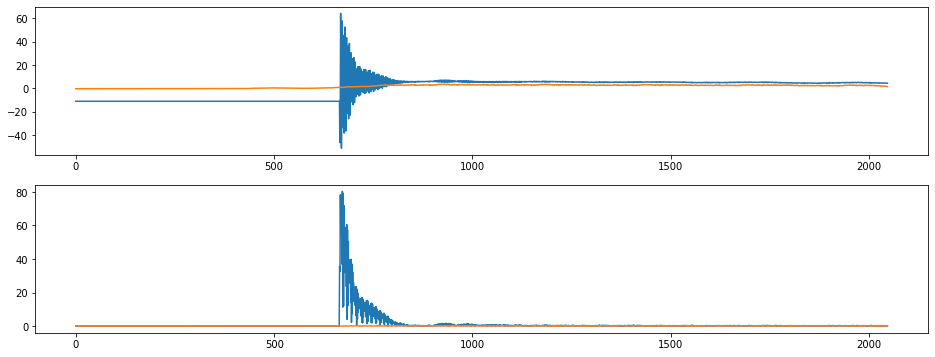

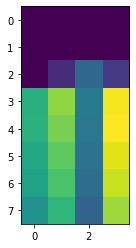

index:  319974
MAE:  5.835282570075069
n_bunches       1916
bunch_index     1094
bunch_number     591
Name: 11485473, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/instability_data/06245_Inst_B1H_Q7_20170926_22h21m15s.h5


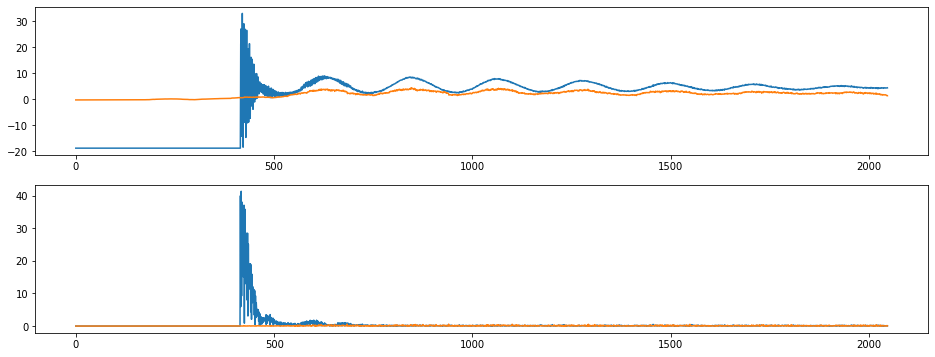

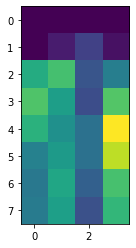

index:  25346
MAE:  5.609544726287713
n_bunches        733
bunch_index     2773
bunch_number     584
Name: 1498130, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_21h45m15s.h5


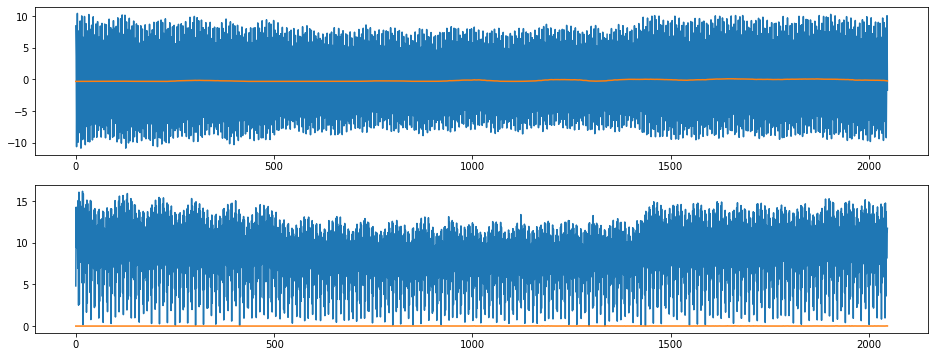

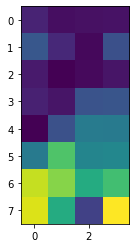

In [47]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()